# Data Wrangling

La première étape de notre projet sera de découvrir, structurer, nettoyer, enrichir nos données. 

Pour cela nous allons dans un premier temps, préparer nos environnement de développement, puis importer nos données à partir des CSV fournis. Nous avons décidé de fusionner toutes ces données dans un unique tableau de données afin de les analyser plus facilement.

## Imports python généraux

Pour effectuer cette analyse nous allons avoir besoin de différentes bibliothèques :
    
* __OS__ : Pour gérer nos intéractions avec les fichiers de données
* __pandas__ : Pour travailler avec des __dataframe__
* __datetime__ : Si nous devons intéragir avec des dates
* __matplotlib__ : Pour afficher des données de manière plus graphique


## Préparation de l'Environnement


In [1]:
# imports
import numpy as np
import os

from numpy.random import default_rng
# stabilité du notebook d'une exécution à l'autre
random=default_rng(42) 

# jolies figures directement dans le notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15,10] 
plt.rcParams["figure.dpi"] = 250
plt.rcParams['axes.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8

# où sauver les figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images") # le dossier doit exister

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

import warnings
warnings.filterwarnings('ignore')

## Import des Données

On récupère les différentes données des CSV puis les regroupons dans les cas où cela semble pertinent:

* Les informations générales
* Les informations sur l'enquête employé
* Les informations sur l'enquête des managers

In [2]:
import pandas as pd

ROW_DATA_PATH = "datasets"

def fetch_row_data(row_data_path=ROW_DATA_PATH):
    if not os.path.isdir(row_data_path):
        os.makedirs(row_data_path)

fetch_row_data()

def load_row_data(_path,filename):
    csv_path = os.path.join(_path,filename)
    return pd.read_csv(csv_path)

general_info = load_row_data(ROW_DATA_PATH, "general_data.csv")
manager_survey = load_row_data(ROW_DATA_PATH,"manager_survey_data.csv")
employee_survey = load_row_data(ROW_DATA_PATH, "employee_survey_data.csv")
in_time = load_row_data(ROW_DATA_PATH, "in_time.csv")
out_time = load_row_data(ROW_DATA_PATH, "out_time.csv")

## Transformation des données de temps

Les données de temps ne sont pas exploitables dans l'état actuel des choses, il faut donc les retravailler.

Nous allons donc essayer d'obtenir la __moyenne du temps de travail par employé__

Différents points d'attentions : 

* Les dates sont stockées en tant que chaine de caractère et ne sont donc pas exploitable
* Certaines données ne sont pas renseignées (NaN), traduisant une absence au travail

Il nous faut donc traduire les dates en objet __datetime__ afin de pouvoir executer des opérations.

Le temps moyen d'un utilisateur au travail lorsqu'il est absent étant de 0, nous pouvons remplacer les NaN par 0.

Commencons donc par enlever les colonnes représentant l'ID des employés (Qui ne nous intéressent pas pour la modification des types de données). Afin de simplifier la supression de cette colonne, Nous avons changer le fichier .csv de base en ajoutant un nom à la première colonne : EmployeeID.


In [3]:
#On enlève les ID dans les 2 jeux
in_time.drop("EmployeeID", axis=1, inplace=True)
out_time.drop("EmployeeID", axis=1, inplace=True)

#On remplace les NaN par 0
in_time.fillna(0, inplace=True)
out_time.fillna(0, inplace=True)

Transformons ensuite les __chaines de caractères__ en __datatime__  :

In [4]:
for date in in_time.columns:
    in_time[date]=pd.to_datetime(in_time[date],errors='ignore',format='%Y-%m-%d %H:%M:%S')
    out_time[date]=pd.to_datetime(out_time[date],errors='ignore',format='%Y-%m-%d %H:%M:%S')

Nous disposons maintenant d'objets __datetime__, ce qui nous permets d'effectuer des opérations :

* Soustraire le out_time et le in_time pour obtenir la valeur exacte de temps passé au travail __par jour__
* Faire une __moyenne pour chaque employé__

In [5]:
workday_time = (out_time-in_time)
workday_mean_time = workday_time.mean(axis=1)

## Coup d'Oeil
### Fusion CSV

Les données general_info, manager_survey et employee_survey sont stockées dans des csv différents. Pour traiter l'ensemble des données plus facilement, nous allons fusionner ces csv sur la colonne EmployeeID.
De plus on ajoute la colonne du nombre d'heures de travail par jour.


In [6]:
dataset = general_info.merge(manager_survey, how='left', on='EmployeeID')
dataset = dataset.merge(employee_survey, how='left', on='EmployeeID')

dataset["AverageWorktime"] = workday_mean_time.dt.total_seconds()/60/60

In [7]:
for cat in ["BusinessTravel","Department","EducationField", "JobRole","MaritalStatus"]:
    print(dataset[cat].value_counts())
    print("----------------------------------------")

Travel_Rarely        3129
Travel_Frequently     831
Non-Travel            450
Name: BusinessTravel, dtype: int64
----------------------------------------
Research & Development    2883
Sales                     1338
Human Resources            189
Name: Department, dtype: int64
----------------------------------------
Life Sciences       1818
Medical             1392
Marketing            477
Technical Degree     396
Other                246
Human Resources       81
Name: EducationField, dtype: int64
----------------------------------------
Sales Executive              978
Research Scientist           876
Laboratory Technician        777
Manufacturing Director       435
Healthcare Representative    393
Manager                      306
Sales Representative         249
Research Director            240
Human Resources              156
Name: JobRole, dtype: int64
----------------------------------------
Married     2019
Single      1410
Divorced     981
Name: MaritalStatus, dtype: int64
----

Dans un premier temps, nous pouvons observer les premières lignes de notre dataset en utilisant la méthode _head()_, afin de vérifier que l'import et la fusion se sont bien passés.

In [8]:
dataset.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AverageWorktime
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,6,1,0,0,3,3,3.0,4.0,2.0,6.554356
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,3,5,1,4,2,4,3.0,2.0,4.0,6.979604
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,2,5,0,3,3,3,2.0,2.0,1.0,6.502698
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,5,8,7,5,2,3,4.0,4.0,3.0,6.477067
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,2,6,0,4,3,3,4.0,1.0,3.0,7.515375


Nous pouvons obtenir une description du dataset avec la méthode _info()_. Ce qui nous permettra de repérer les attributs contenant des données vides et de connaitre le type des valeurs de chaque attribut.

In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 0 to 4409
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

### Vue d'ensemble sur nos données
Pour cette vue d'ensemble, l'attribut "EmployeeID" ne nous est pas utile, nous créons donc une copie de notre dataset pour pouvoir supprimer cet attribut.

In [10]:
dataset_copy = dataset.copy()
dataset_copy.drop("EmployeeID", axis=1, inplace=True)
dataset_copy.describe()

,Age,DistanceFromHome,Education,EmployeeCount,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,StockOptionLevel,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AverageWorktime
count,4410.000000,4410.000000,4410.000000,4410.0,4410.000000,4410.000000,4391.000000,4410.000000,4410.0,4410.000000,...,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4385.000000,4390.000000,4372.000000,4410.000000
mean,36.923810,9.192517,2.912925,1.0,2.063946,65029.312925,2.694830,15.209524,8.0,0.793878,...,2.799320,7.008163,2.187755,4.123129,2.729932,3.153741,2.723603,2.728246,2.761436,6.978070
std,9.133301,8.105026,1.023933,0.0,1.106689,47068.888559,2.498887,3.659108,0.0,0.851883,...,1.288978,6.125135,3.221699,3.567327,0.711400,0.360742,1.092756,1.101253,0.706245,1.269584
min,18.000000,1.000000,1.000000,1.0,1.000000,10090.000000,0.000000,11.000000,8.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,1.000000,1.000000,1.000000,5.167828
25%,30.000000,2.000000,2.000000,1.0,1.000000,29110.000000,1.000000,12.000000,8.0,0.000000,...,2.000000,3.000000,0.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,5.990699
50%,36.000000,7.000000,3.000000,1.0,2.000000,49190.000000,2.000000,14.000000,8.0,1.000000,...,3.000000,5.000000,1.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,6.688821
75%,43.000000,14.000000,4.000000,1.0,3.000000,83800.000000,4.000000,18.000000,8.0,1.000000,...,3.000000,9.000000,3.000000,7.000000,3.000000,3.000000,4.000000,4.000000,3.000000,7.537530
max,60.000000,29.000000,5.000000,1.0,5.000000,199990.000000,9.000000,25.000000,8.0,3.000000,...,6.000000,40.000000,15.000000,17.000000,4.000000,4.000000,4.000000,4.000000,4.000000,10.434399


On peut utiliser la fonction _hist()_ et _matplotlib_ pour afficher un histogramme par attribut numérique.

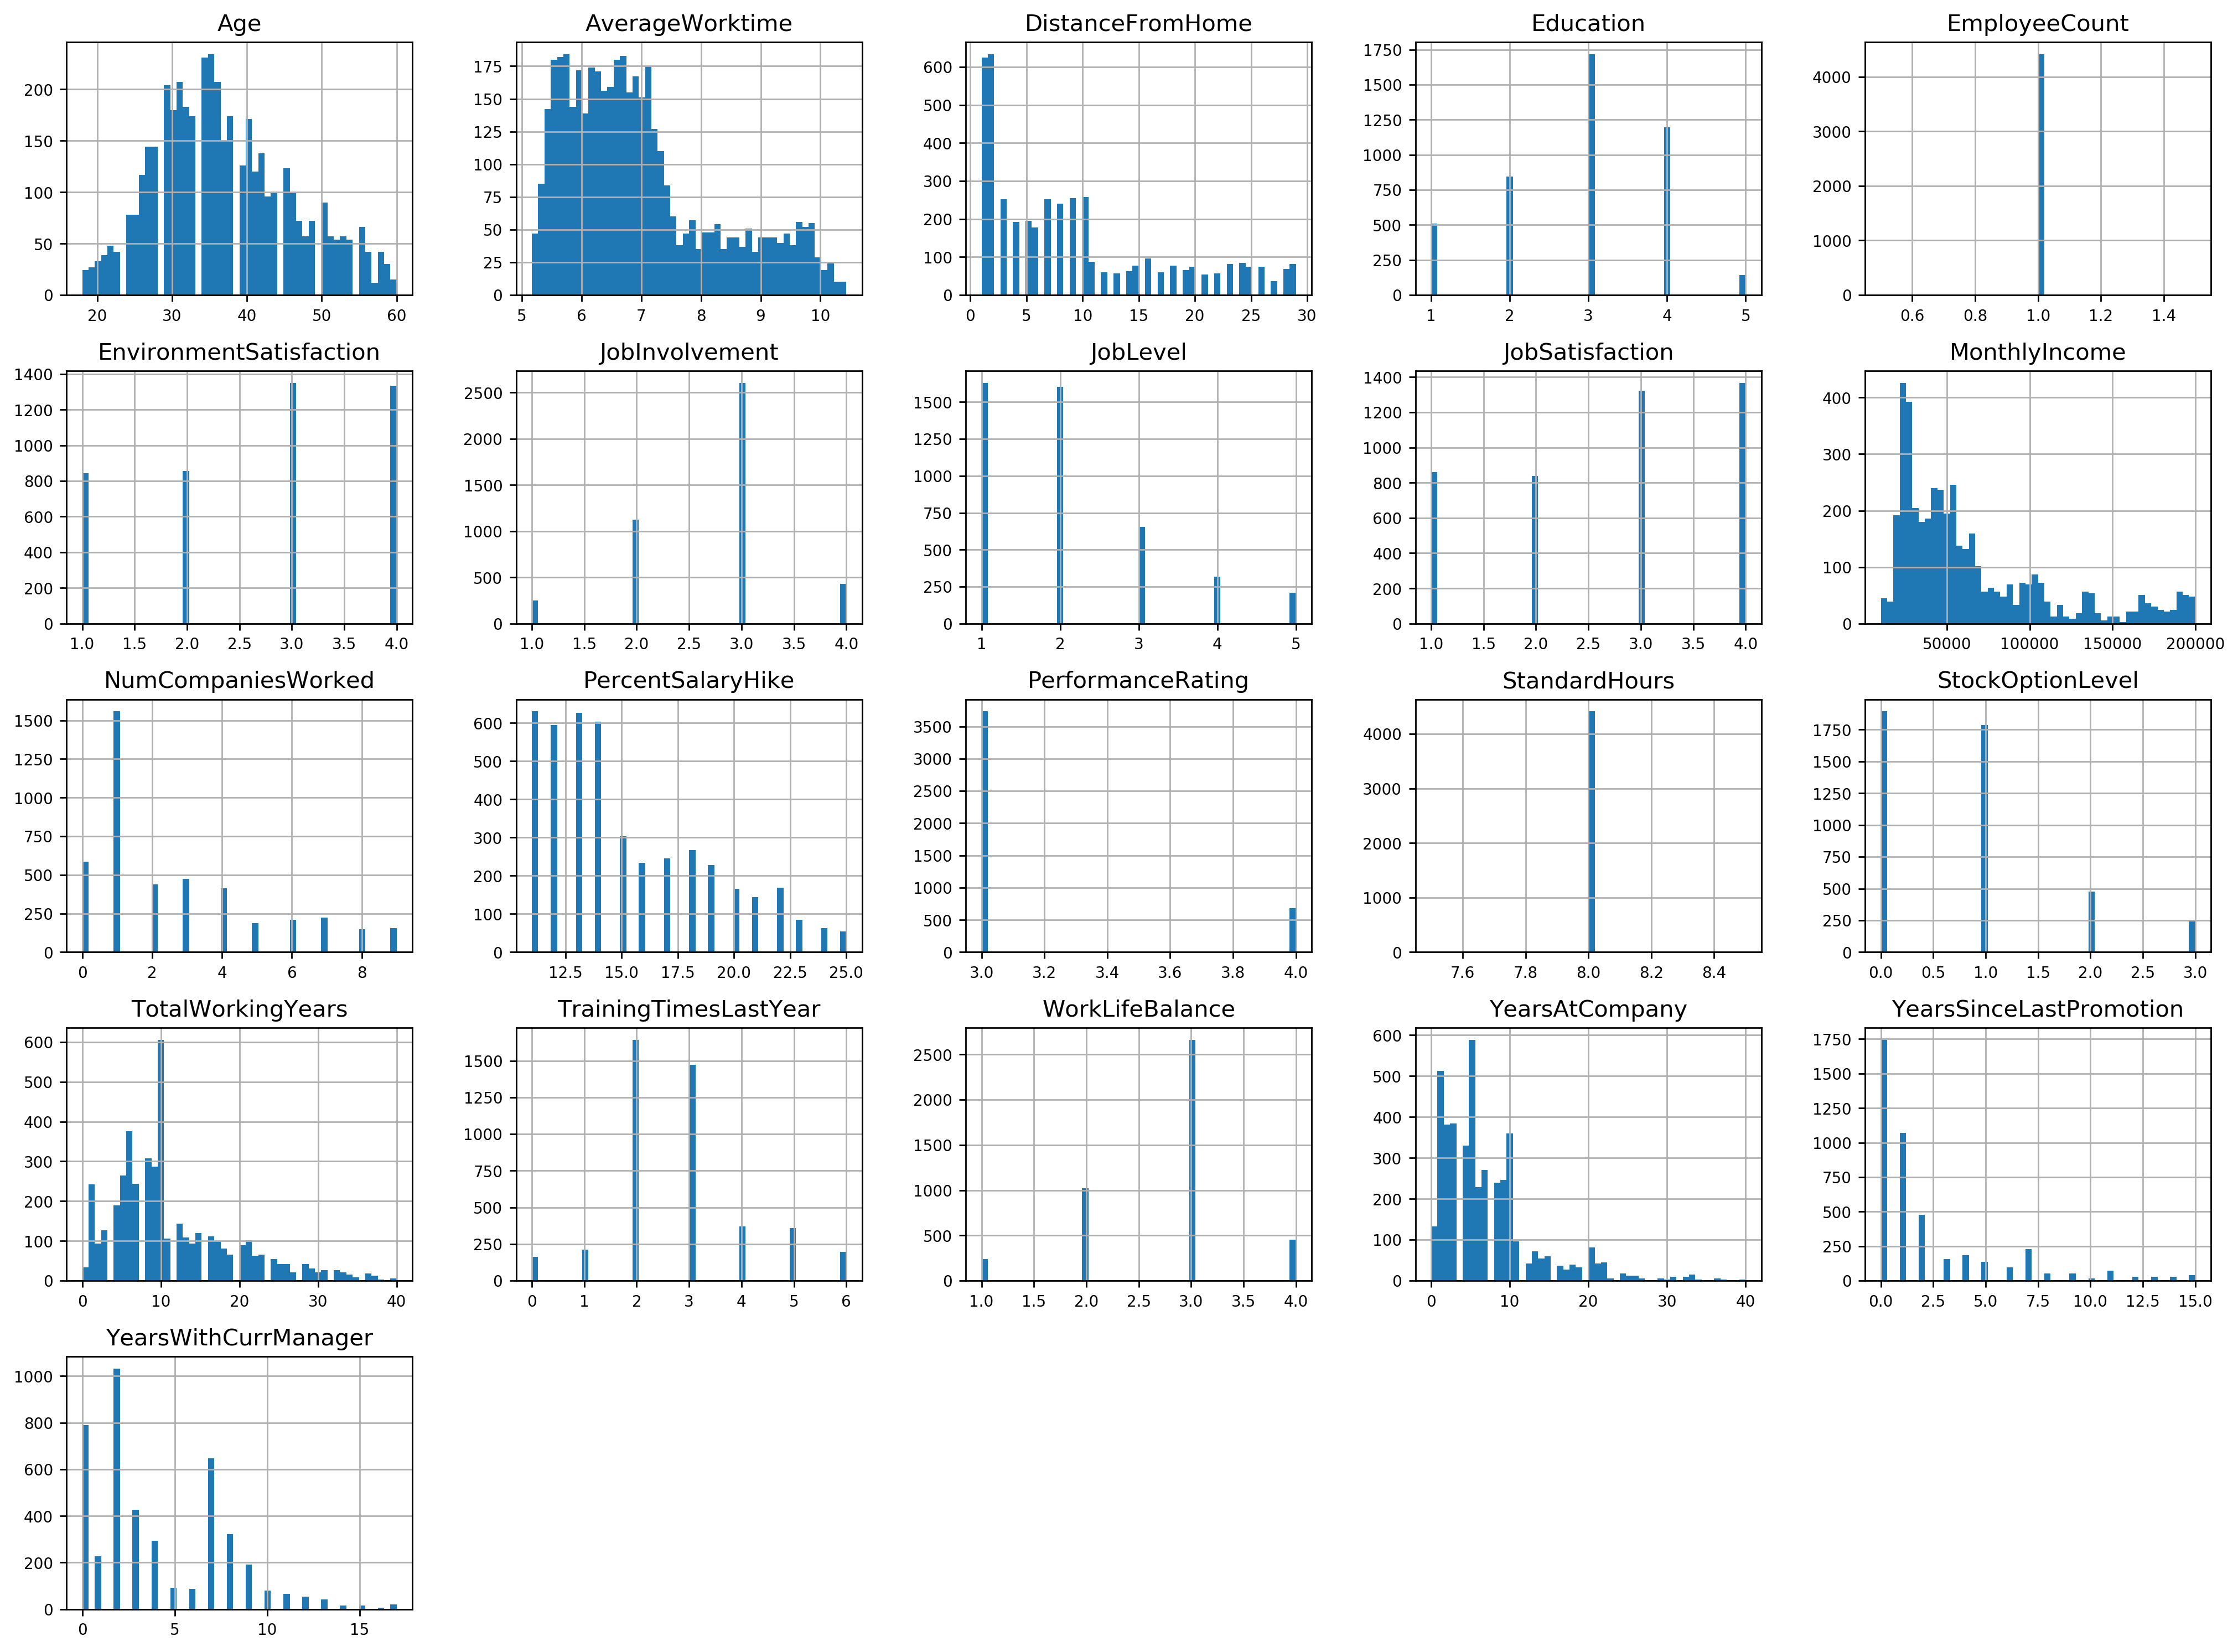

In [11]:
dataset_copy.hist(bins=50, figsize=(20,15))
plt.show()

## Pipeline de transformation de données quantitatives
Nous créons un pipeline pour remplacer toutes nos valeurs non renseignées par la médiane de l'attribut à l'aide de _SimpleImputer_. Nous devons mettre nos données à la même échelle pour faciliter l'analyse, pour cela nous utilisons _StandardScaler_.

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

## Pipeline de transformation de données qualitatives

Nous devons numériser nos données qualitives afin de pouvoir les analyser et les utiliser dans nos futurs modèles. Pour cela, deux choix s'offrent à nous, OrdinaleEncoder et OneHotEncoder. 

- OrdinalEncoder : Donne une valeur numérique à chaque catégorie (ex: ['pomme, poire, banane] => [0,1,2])
- OneHotEncoder : Chaque catégorie va donner naissance à une nouvelle variable booléenne (ex: ['pomme, poire, banane] => [[1,0,0],[0,1,0],[0,0,1]])

Par conséquent, nous avons choisi d'utiliser OneHotEncoder, car certain algorithme de ML peuvent considérer que des valeurs numériques telles que  0  et  1  sont plus proches l'une de l'autre que ne le sont  0  et  2 . Ce n'est a priori pas vrai ici si on mappe les catégories trivialement sur [0,1,2]. Le 1-hot encoding palie ce problème. 

In [13]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

dataset_num = dataset.select_dtypes(include = [np.number])

num_attribs = list(dataset_num)
cat_attribs = ["BusinessTravel","Department","EducationField", "JobRole","MaritalStatus"]
bin_attribs = ["Attrition","Over18","Gender"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
        ("cat_binary",OrdinalEncoder(),bin_attribs),
    ])


dataset_prepared = full_pipeline.fit_transform(dataset)

In [14]:
dataset_prepared.shape
num_attribs

['Age',
 'DistanceFromHome',
 'Education',
 'EmployeeCount',
 'EmployeeID',
 'JobLevel',
 'MonthlyIncome',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'StandardHours',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'YearsAtCompany',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager',
 'JobInvolvement',
 'PerformanceRating',
 'EnvironmentSatisfaction',
 'JobSatisfaction',
 'WorkLifeBalance',
 'AverageWorktime']

In [15]:
dataframe_prepared = pd.DataFrame(dataset_prepared)
ordered_subcat = num_attribs.copy()
for cat in cat_attribs:
    for subcat in sorted(dataset[cat].unique()):
        if subcat in ordered_subcat:
            ordered_subcat.append(cat + "_" + subcat)
        else:
            ordered_subcat.append(subcat)
for attrib in bin_attribs:
    ordered_subcat.append(attrib)

dataframe_prepared.columns = ordered_subcat

In [16]:
dataframe_prepared.head(5)

,Age,DistanceFromHome,Education,EmployeeCount,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,...,Research Director,Research Scientist,Sales Executive,Sales Representative,Divorced,Married,Single,Attrition,Over18,Gender
0,1.541369,-0.393938,-0.891688,0.0,-1.731658,-0.961486,1.405136,-0.678464,-1.150554,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,-0.648668,0.099639,-1.868426,0.0,-1.730873,-0.961486,-0.491661,-1.079486,2.129306,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,-0.539166,0.963398,1.061787,0.0,-1.730087,1.749610,2.725053,-0.678464,-0.057267,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.117845,-0.887515,2.038524,0.0,-1.729302,0.845911,0.386301,0.123580,-1.150554,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,-0.539166,0.099639,-1.868426,0.0,-1.728516,-0.961486,-0.884109,0.524602,-0.877232,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [17]:
dataset.head(5)

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AverageWorktime
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,6,1,0,0,3,3,3.0,4.0,2.0,6.554356
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,3,5,1,4,2,4,3.0,2.0,4.0,6.979604
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,2,5,0,3,3,3,2.0,2.0,1.0,6.502698
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,5,8,7,5,2,3,4.0,4.0,3.0,6.477067
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,2,6,0,4,3,3,4.0,1.0,3.0,7.515375


## Correlatrion inter-données

Sachant que nous chercherons à prédire __l'attrition__, il parait intéréssant de voir quelles sont les données les plus corrélées avec cette dernière, nous allons donc monter une matrice de corrélation sur le jeu de données global (Avec nos différentes données mises en forme) pour trouver cette variable.
Afin d'avoir une matrice de correlation effective nous allons numériser toutes les données non numeriques. Pour cela nous allons utiliser l'encodeur Ordinal

In [18]:
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

corrMatrix = dataframe_prepared.corr()
print (corrMatrix)

corr = corrMatrix.values


                                     Age  DistanceFromHome  Education  \
Age                             1.000000          0.006963  -0.035706   
DistanceFromHome                0.006963          1.000000  -0.008638   
Education                      -0.035706         -0.008638   1.000000   
EmployeeCount                        NaN               NaN        NaN   
EmployeeID                      0.008649         -0.001097  -0.009680   
JobLevel                       -0.002884         -0.037329   0.045746   
MonthlyIncome                  -0.044314         -0.021607   0.006410   
NumCompaniesWorked              0.298869         -0.013514  -0.016195   
PercentSalaryHike              -0.033137          0.038125  -0.040531   
StandardHours                        NaN               NaN        NaN   
StockOptionLevel               -0.031753          0.011169   0.001261   
TotalWorkingYears               0.680340          0.009314  -0.010813   
TrainingTimesLastYear          -0.027308         -0

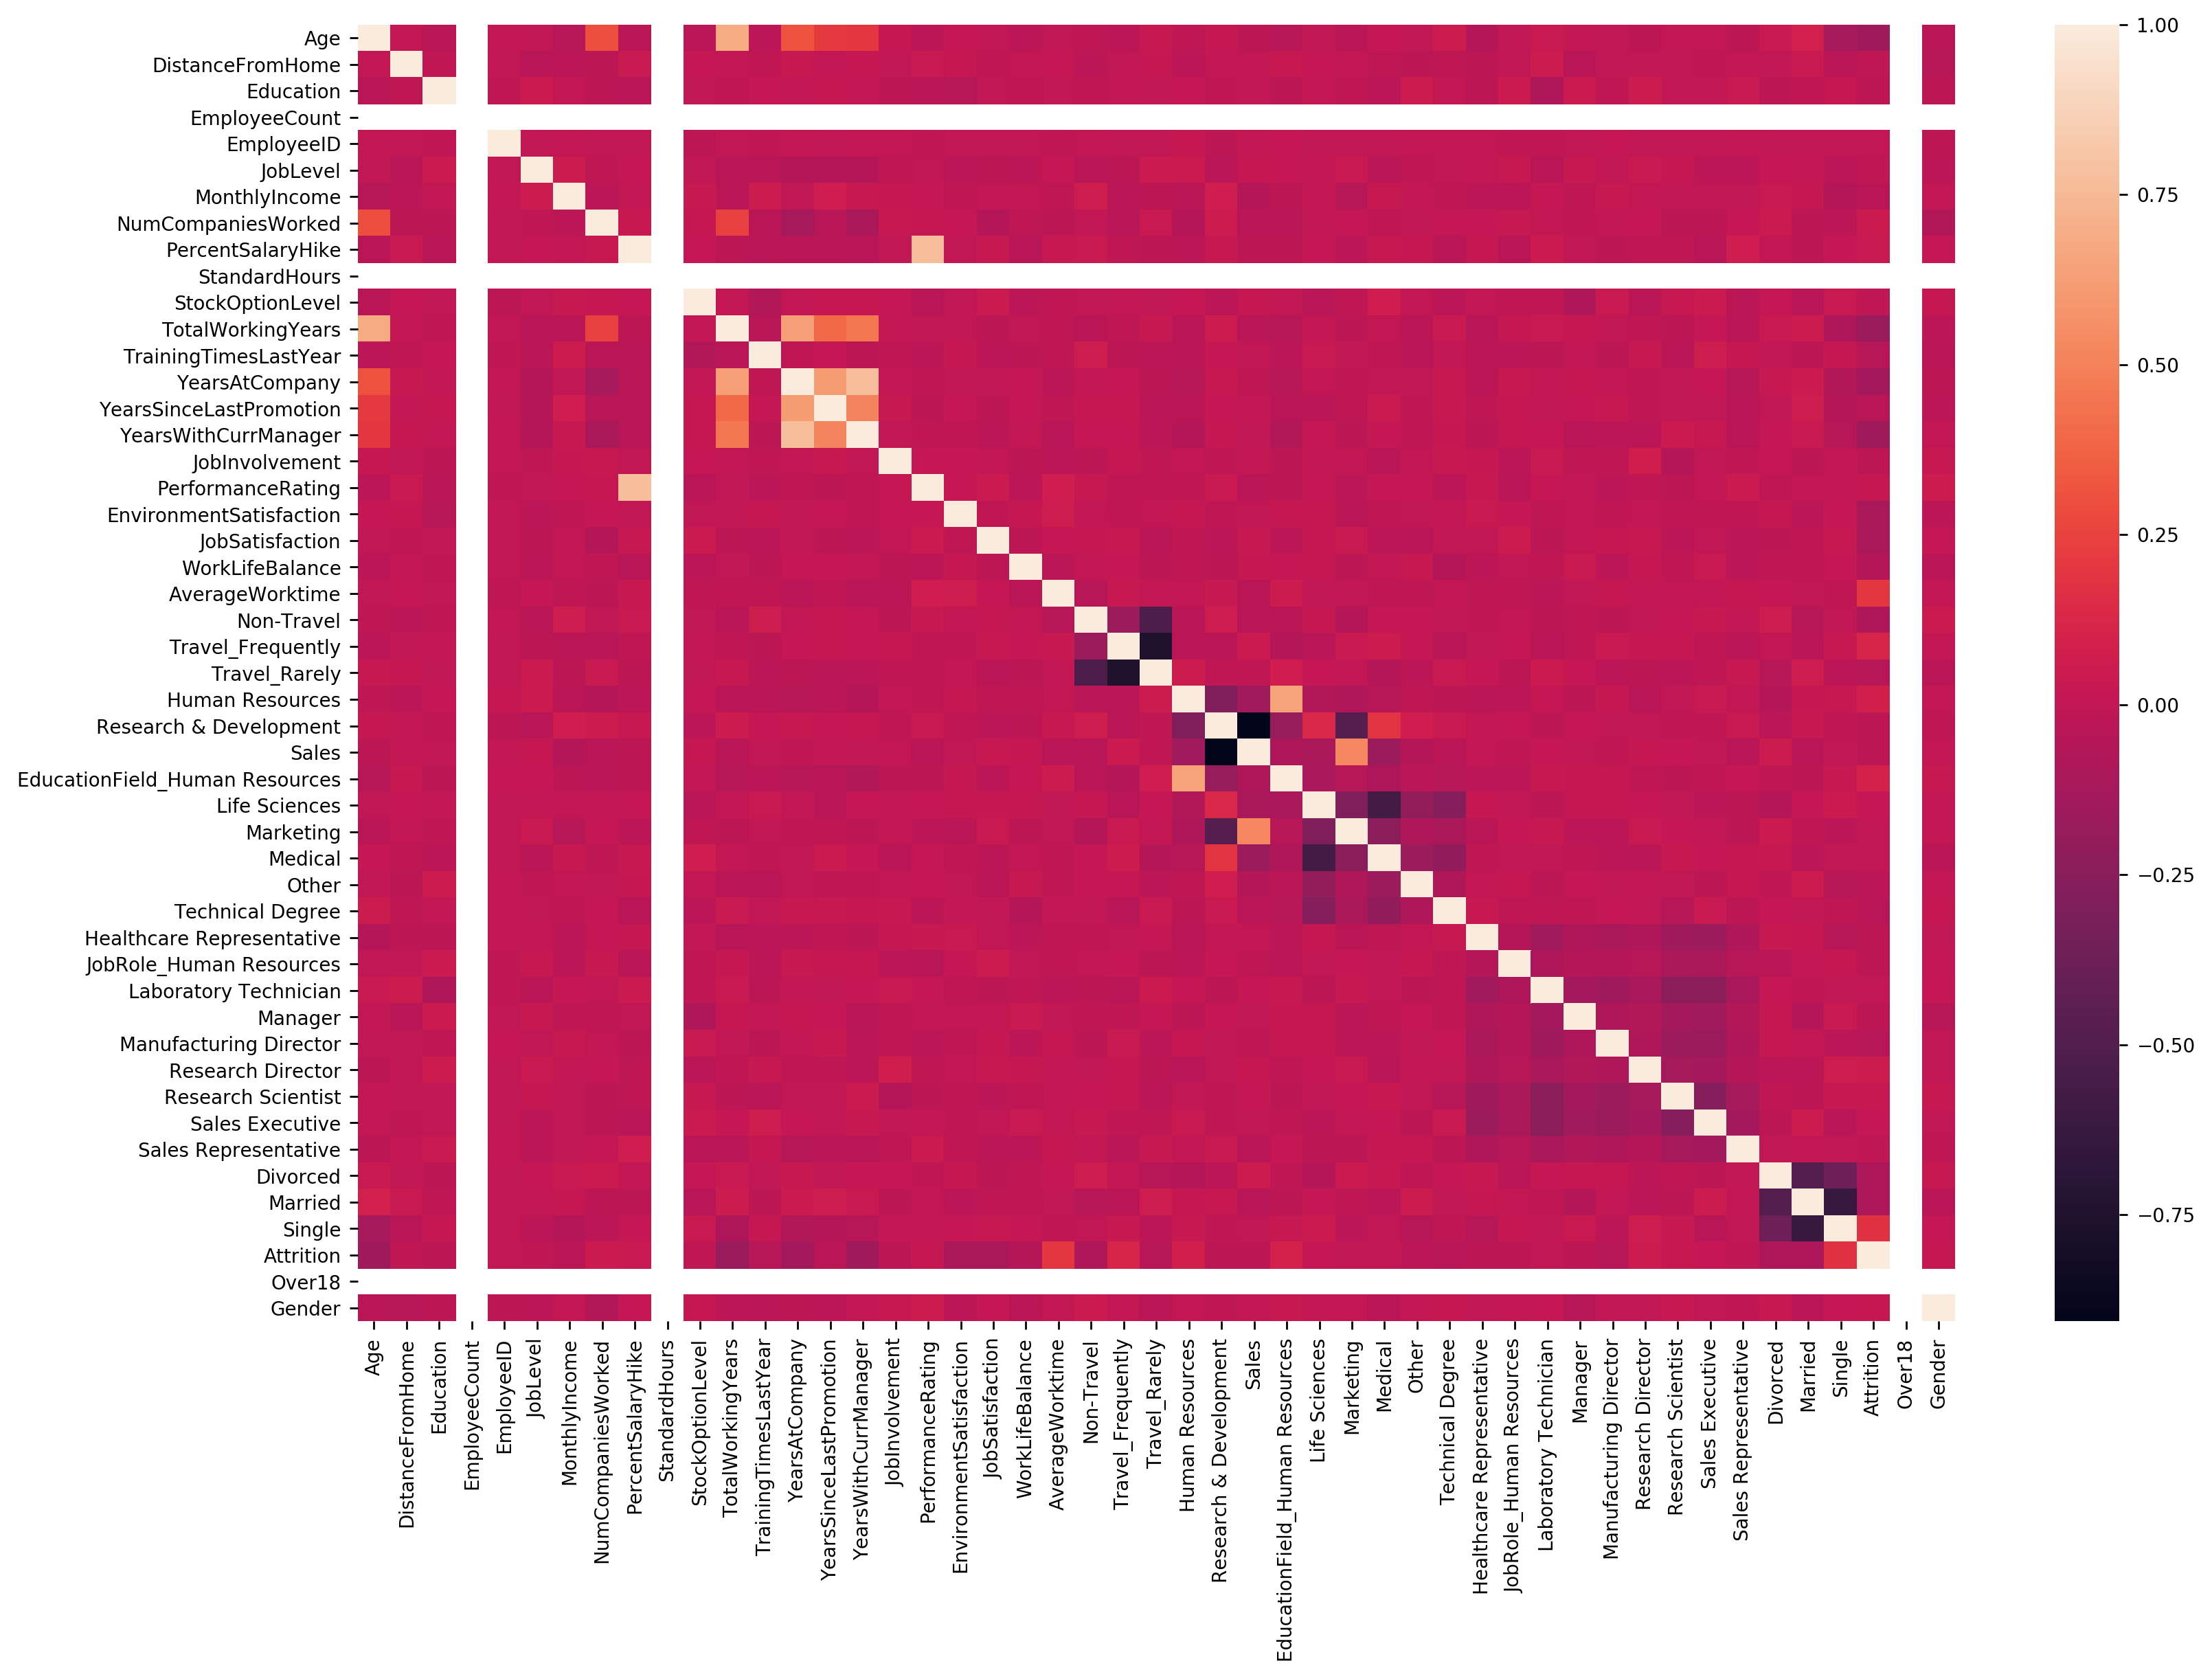

Attrition                         1.000000
AverageWorktime                   0.198890
Single                            0.175419
Travel_Frequently                 0.115143
EducationField_Human Resources    0.091573
Human Resources                   0.080768
Research Director                 0.049760
NumCompaniesWorked                0.042064
PercentSalaryHike                 0.032533
Research Scientist                0.027460
PerformanceRating                 0.023403
Gender                            0.018125
Life Sciences                     0.012394
Sales Executive                   0.010869
Laboratory Technician             0.001179
Medical                           0.000764
Marketing                        -0.003780
EmployeeID                       -0.004729
StockOptionLevel                 -0.006839
DistanceFromHome                 -0.009730
JobLevel                         -0.010290
Sales Representative             -0.011073
Healthcare Representative        -0.013768
JobRole_Hum

In [19]:
## Affichage sous forme de heatmap
sn.heatmap(corrMatrix, annot=False)
plt.show()
corrMatrix["Attrition"].sort_values(ascending=False)

## Création d'un jeu de test aléatoire

Nous allons diviser notre jeu de données en un jeu de test et un jeu d'entrainement en se basant sur la valeur la plus corrélée défini ci-dessus (AverageWortime = 0.198890). 

Pour cela nous allons utiliser la méthode StratifiedShuffleSplit car nous désirons effectuer un échantillonage où les jeux d'entraînement et de test respectent les proportions de représentation des différentes catégories d'heure de travail par jour.

Notre jeu de test représentera 20% de notre jeu de donnée.

Pour éviter les biais de sous-représentation ou sur-représentation, on essaye d'avoir un nombre limité de strates. 

In [20]:
dataset["AverageWorktimeCat"] = np.ceil(dataset["AverageWorktime"])
print(dataset["AverageWorktimeCat"].value_counts())

7.0     1555
6.0     1118
8.0      829
10.0     428
9.0      413
11.0      67
Name: AverageWorktimeCat, dtype: int64


Nous pouvons voir que nous avons 6 strates différentes, dont une ne comprenant que 67 valeurs. Nous allons donc regrouper le nombre d'heure de travail supérieur à 10.

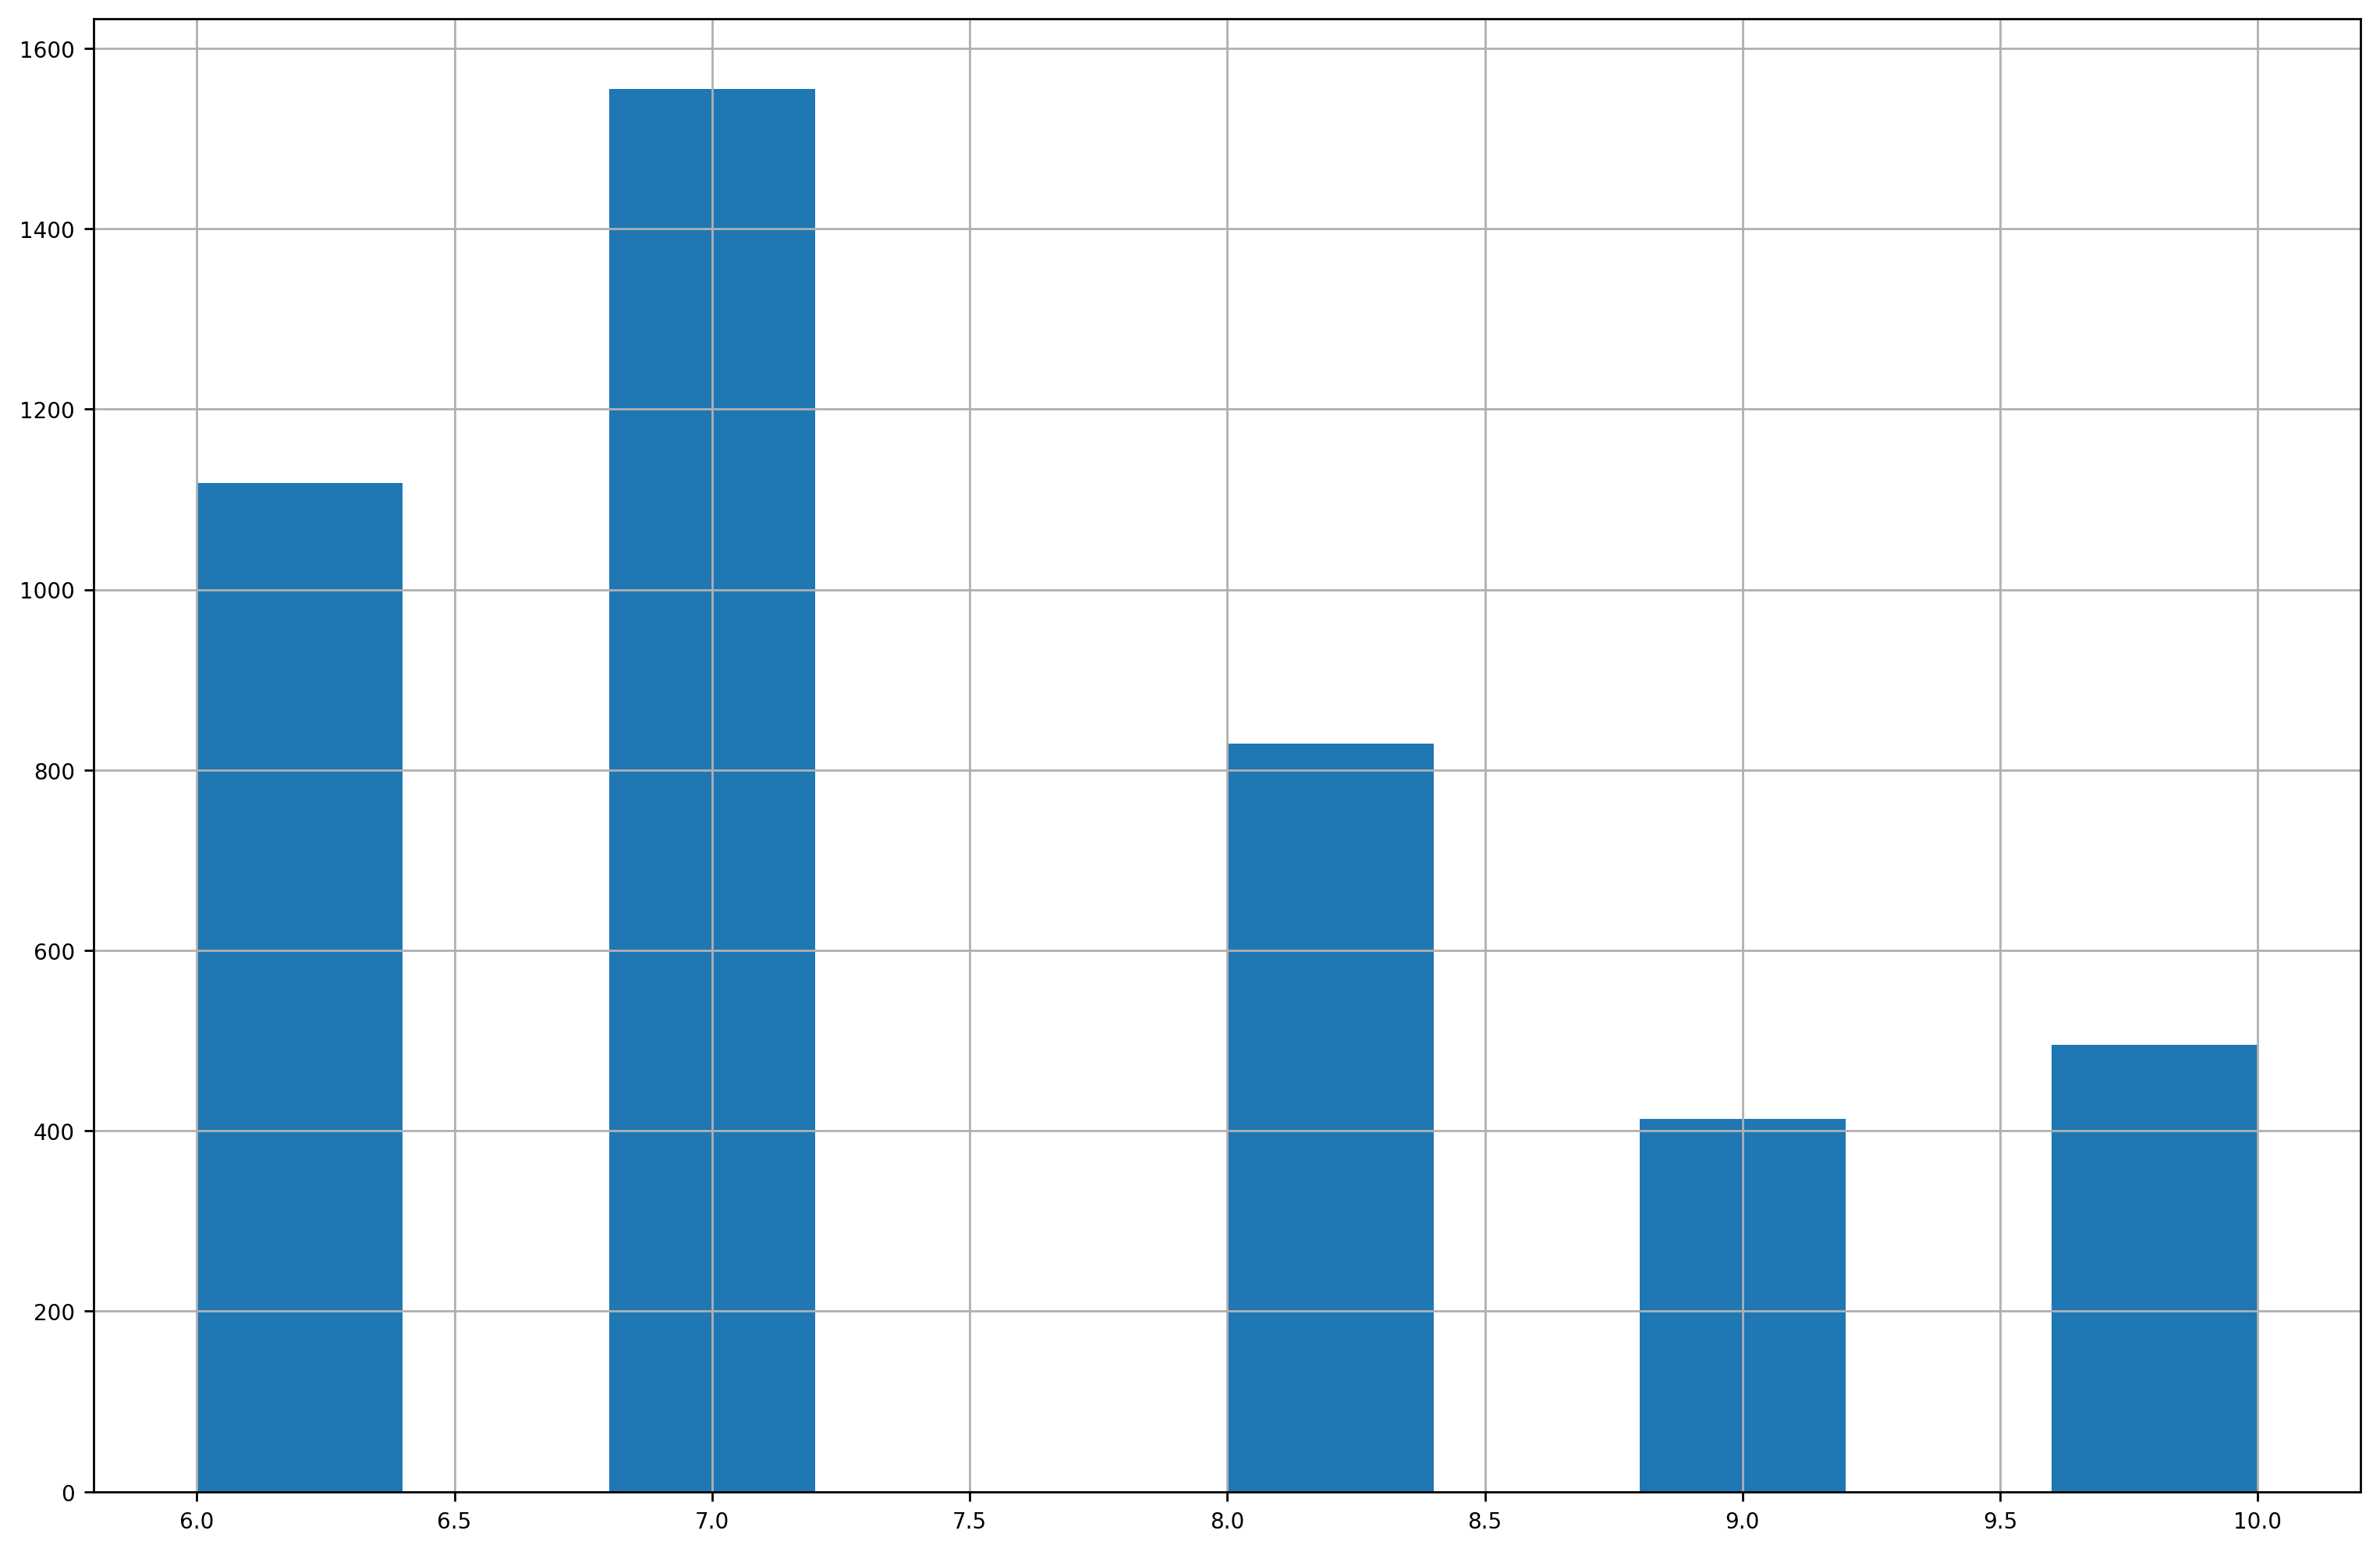

In [21]:
dataset["AverageWorktimeCat"].where(dataset["AverageWorktimeCat"] < 10, 10.0, inplace=True)
dataset["AverageWorktimeCat"].hist()

Nous pouvons à présent utiliser la fonction StratifiedShuffleSplit de la bibliothèque sklearn afin de diviser notre jeu de données.

In [22]:
from sklearn.model_selection import StratifiedShuffleSplit

stratifiedSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in stratifiedSplit.split(dataset, dataset["AverageWorktimeCat"]):
    print(train_index, test_index) # 1 seul tour de boucle si n_splits = 1
    strat_train_set = dataset.loc[train_index]
    strat_test_set = dataset.loc[test_index]


[3575 2406 3168 ... 2555 2426 3665] [ 214 3414   18 3498  863 2739 1741 1826 1551 2441 3476 4123 1827 2514
  480 2562 1703  772  441   34  174  142 1347  305 4310 1596 3746 2906
 3388 3260 2746 2819  667  624 2314 4094  758   12  710  687  267 3197
 3034 4077  794 3527  114  301 3319  533 1059  542 3299 3624 2050 3751
  466 4293 3734 3312 2753 1792 2775 1725   91 4214 3814 2409 4019  379
   49  928 2664 2978 2450 4299 2843  965  679  166 3964 1008 3893 1197
 1858  562 1800 1912 1133 3795 2885 3370 4348 4178 3072 2072 1206 2774
  873 3193 2440 2202 4237 1457 2694 2103  427    8  917 1737  310 3381
 2267  676 1538  350 1397 3185  383 3965 3956   93 4400 3266 1949   70
 3424 4285 3250 2076 3360  269   20  938 4160 1161 2303 3936 1182 3714
 2858  932 3440  854 2110 3117  549 3767 2275 2738 3386 2258 3896 1392
 1074 3762 1026 1533 1083  770 2994 2598 1892 1977 2601 1315  807  463
 2168 3927  696  998 4190 3199 2201 3832  738 1960  317 2709 2796 3341
 2121 1230 1395 2146 3002 2414  398 1655 

Vérifions que les proportions sont bien respectées.

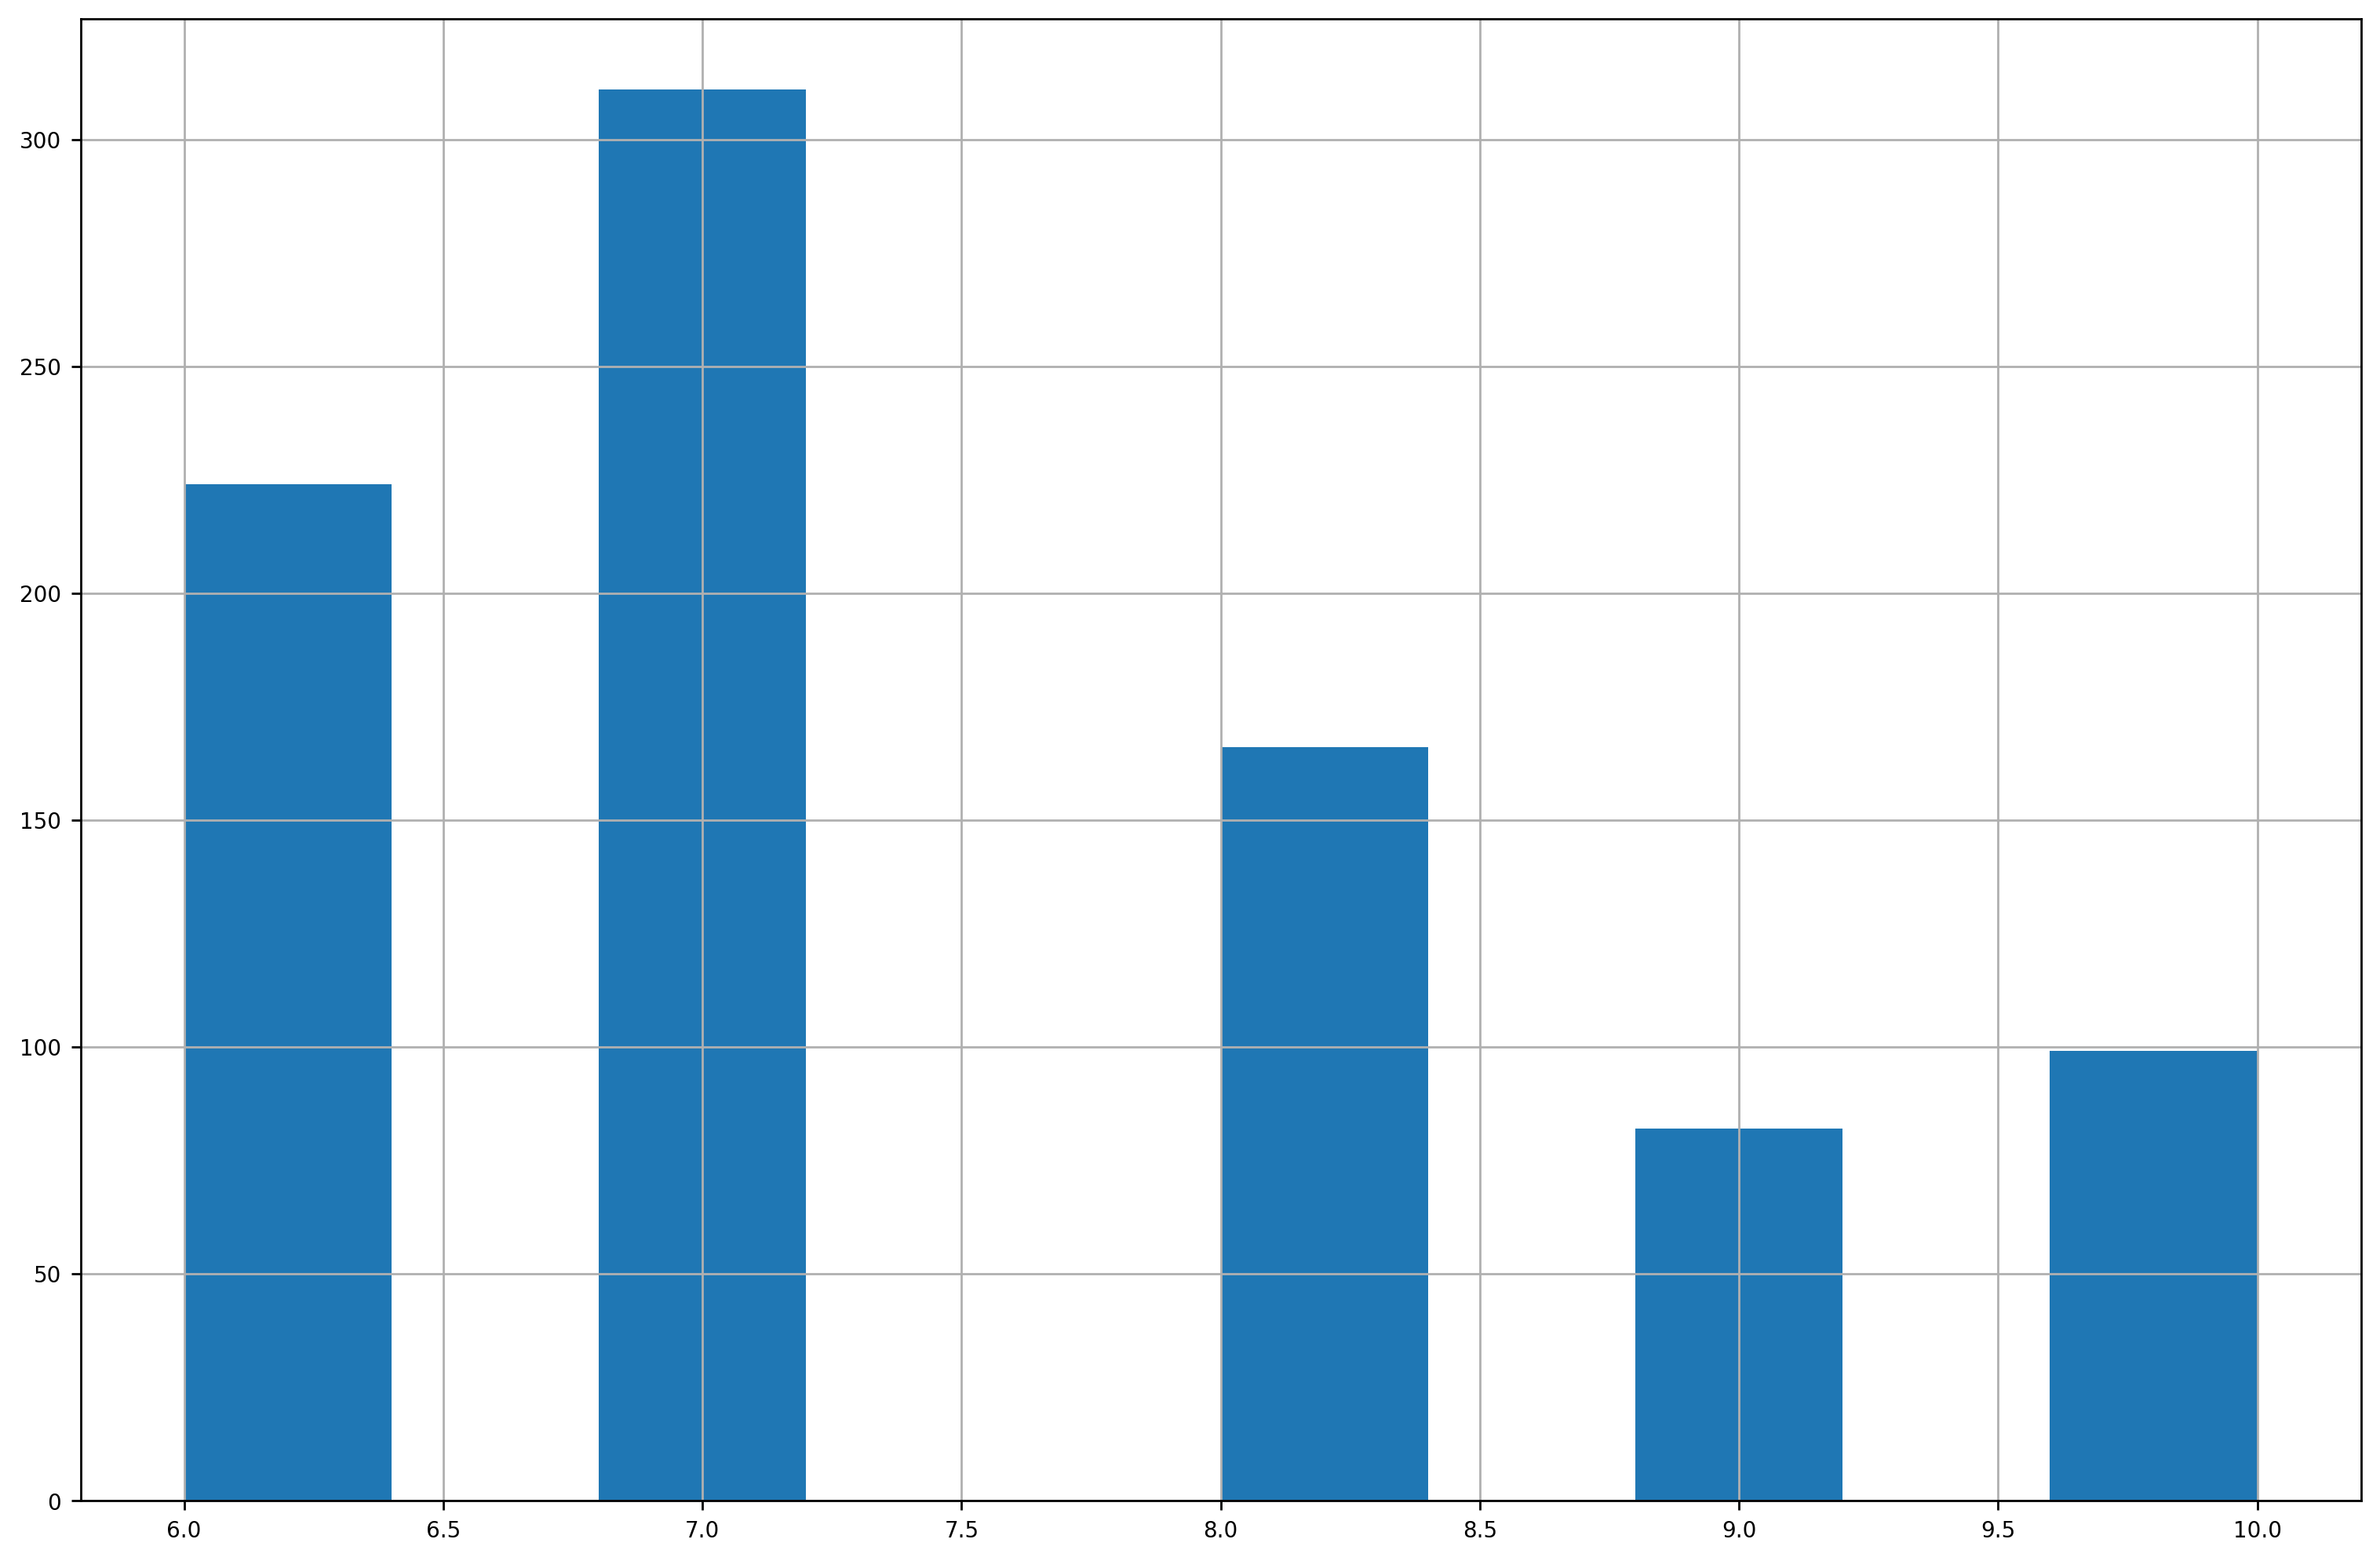

In [23]:
strat_test_set["AverageWorktimeCat"].hist()

Les proportions étant bien respectées, nous pouvons supprimer cette colonne de notre dataset et créer une copie afin d'éviter toute mauvaise manipulation.

In [24]:
dataset_train_labels = strat_train_set['Attrition'].copy()
dataset_train_labels.where(dataset_train_labels == "Yes", 0, inplace=True)
dataset_train_labels.where(dataset_train_labels == 0, 1, inplace=True)
dataset_train_labels = dataset_train_labels.astype(np.int64)

for set_ in (strat_train_set, strat_test_set):
    set_.drop("AverageWorktimeCat", axis=1, inplace=True)

dataset_train = strat_train_set.copy()
dataset_train.drop("Attrition", axis=1, inplace=True)

## Préparation des données d'entrainement

Comme effectué précédement, préparons notre jeu d'entrainement à l'aide de notre pipeline de préparation.

In [25]:
dataset_train_num = dataset_train.select_dtypes(include = [np.number])

num_train_attribs = list(dataset_train_num)
cat_train_attribs = ["BusinessTravel","Department","EducationField", "JobRole","MaritalStatus"]
bin_train_attribs = ["Over18","Gender"]

full_train_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_train_attribs),
        ("cat", OneHotEncoder(), cat_train_attribs),
        ("cat_binary",OrdinalEncoder(),bin_train_attribs),
    ])


In [26]:
dataset_train_prepared = full_train_pipeline.fit_transform(dataset_train)

## Entrainement et Tests de Différents Modèles

Afin de trouver le modèle offrant les meilleures performances dans notre cas, nous allons en tester plusieurs et selectionner le modèle aillant les meileurs résultats.
Les modèles testés sont :
* La regression Logistique
* Le Perceptron
* La Descente de Gradient Stochastique
* Le Random Forest Classifier

### Regression Logistique

In [27]:
from sklearn.linear_model import LogisticRegression

logistic_reg = LogisticRegression()
logistic_reg.fit(dataset_train_prepared,dataset_train_labels)
logistic_reg_pred = logistic_reg.predict(dataset_train_prepared)

In [28]:
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
logistic_reg_scores = cross_val_score(logistic_reg, dataset_train_prepared, 
                                      dataset_train_labels, cv=7, scoring="f1")

display_scores(logistic_reg_scores)

Scores: [0.32432432 0.36666667 0.32075472 0.41666667 0.3826087  0.41025641
 0.24761905]
Mean: 0.3526995040237745
Standard deviation: 0.05524201207700728


#### Paramétrage du modèle (_fine tuning_)

Afin de trouver les meilleurs paramètres, nous allons utiliser la méthode d'optimisation GridSearchCV.

In [29]:
from sklearn.model_selection import GridSearchCV

logistic_reg_param_grid = [
    {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'penalty': ['none', 'l1', 'l2', 'elasticnet'], 
     'C': [100, 10, 1.0, 0.1, 0.01]}
  ]

grid_search = GridSearchCV(logistic_reg, logistic_reg_param_grid, cv=7,
                           scoring='f1', return_train_score=True)
grid_search.fit(dataset_train_prepared, dataset_train_labels)

GridSearchCV(cv=7, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [100, 10, 1.0, 0.1, 0.01],
                          'penalty': ['none', 'l1', 'l2', 'elasticnet'],
                          'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                     'saga']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scorin

In [30]:
grid_search.best_params_

{'C': 100, 'penalty': 'none', 'solver': 'newton-cg'}

In [31]:
best_logistic_reg = grid_search.best_estimator_

In [32]:
best_logistic_reg_score = cross_val_score(best_logistic_reg, dataset_train_prepared, 
                                          dataset_train_labels, cv=7, scoring="f1")

display_scores(best_logistic_reg_score)

Scores: [0.33928571 0.3697479  0.3364486  0.41666667 0.37931034 0.40336134
 0.24528302]
Mean: 0.355729083782316
Standard deviation: 0.05288164563028432


On peut voir que le modèle s'est un peu amélioré, comme l'on peut le voir avec la moyenne du f1_score

#### Matrice de Confusion

Nous allons maintenant utiliser afin d'étudier les performances de notre système de classification supervisé. Calculons maintenant cette matrice avec notre modèle amélioré.

In [33]:
from sklearn.model_selection import cross_val_predict

dataset_train_label_true = (dataset_train_labels == 1)

best_logistic_reg_pred = cross_val_predict(best_logistic_reg, dataset_train_prepared, dataset_train_label_true, cv=7)

In [34]:
from sklearn.metrics import confusion_matrix

confusion_matrix(dataset_train_label_true, best_logistic_reg_pred)

array([[2872,   85],
       [ 428,  143]], dtype=int64)

In [35]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision_score(dataset_train_label_true, best_logistic_reg_pred)

0.6271929824561403

In [36]:
recall_score(dataset_train_label_true, best_logistic_reg_pred)

0.2504378283712785

In [37]:
f1_score(dataset_train_label_true, best_logistic_reg_pred)

0.3579474342928661

#### Recall et precision en fonction du seuil

Affichons les valeurs du recall et de la précision en fonction du seuil ainsi que la valeur de la précision en fonction du recall

In [38]:
y_scores = cross_val_predict(best_logistic_reg, dataset_train_prepared, dataset_train_label_true, cv=7,
                             method="decision_function")

In [39]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(dataset_train_label_true, y_scores)

Saving figure precision_recall_vs_threshold_plot


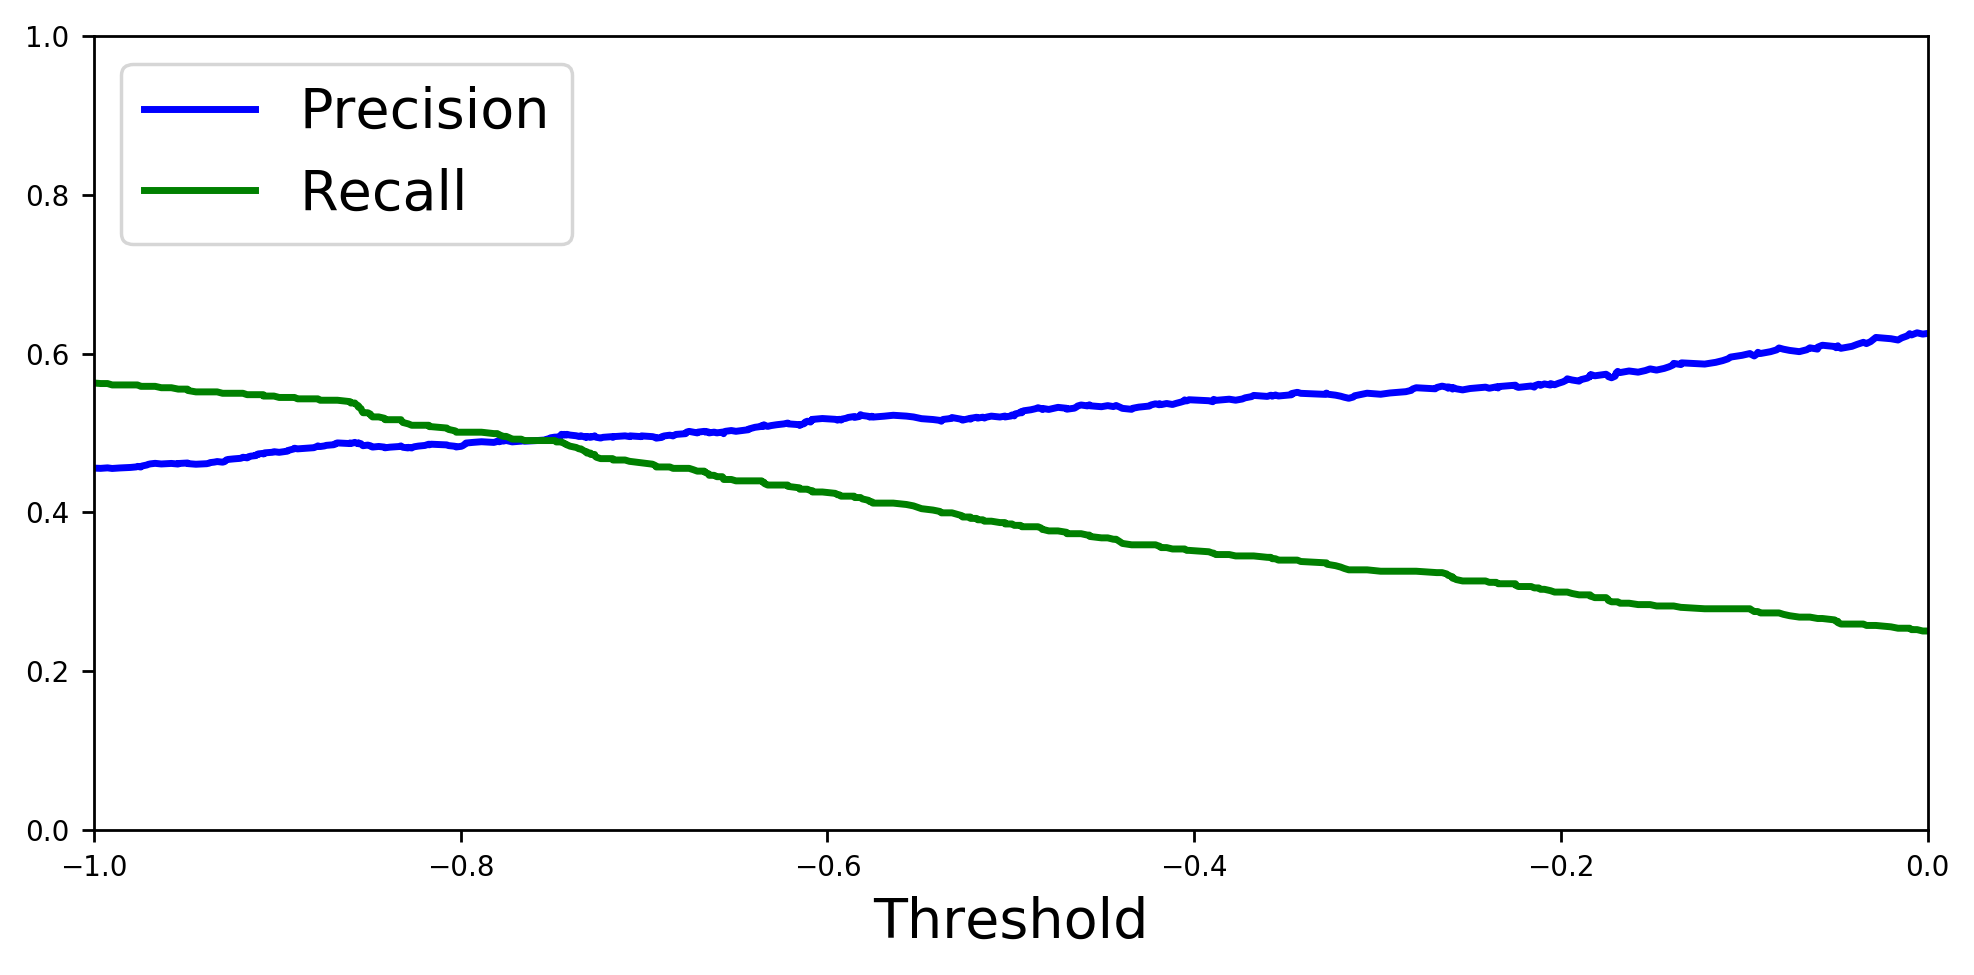

In [40]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b-", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-1, 0])
save_fig("precision_recall_vs_threshold_plot")
plt.show()

Saving figure precision_vs_recall_plot


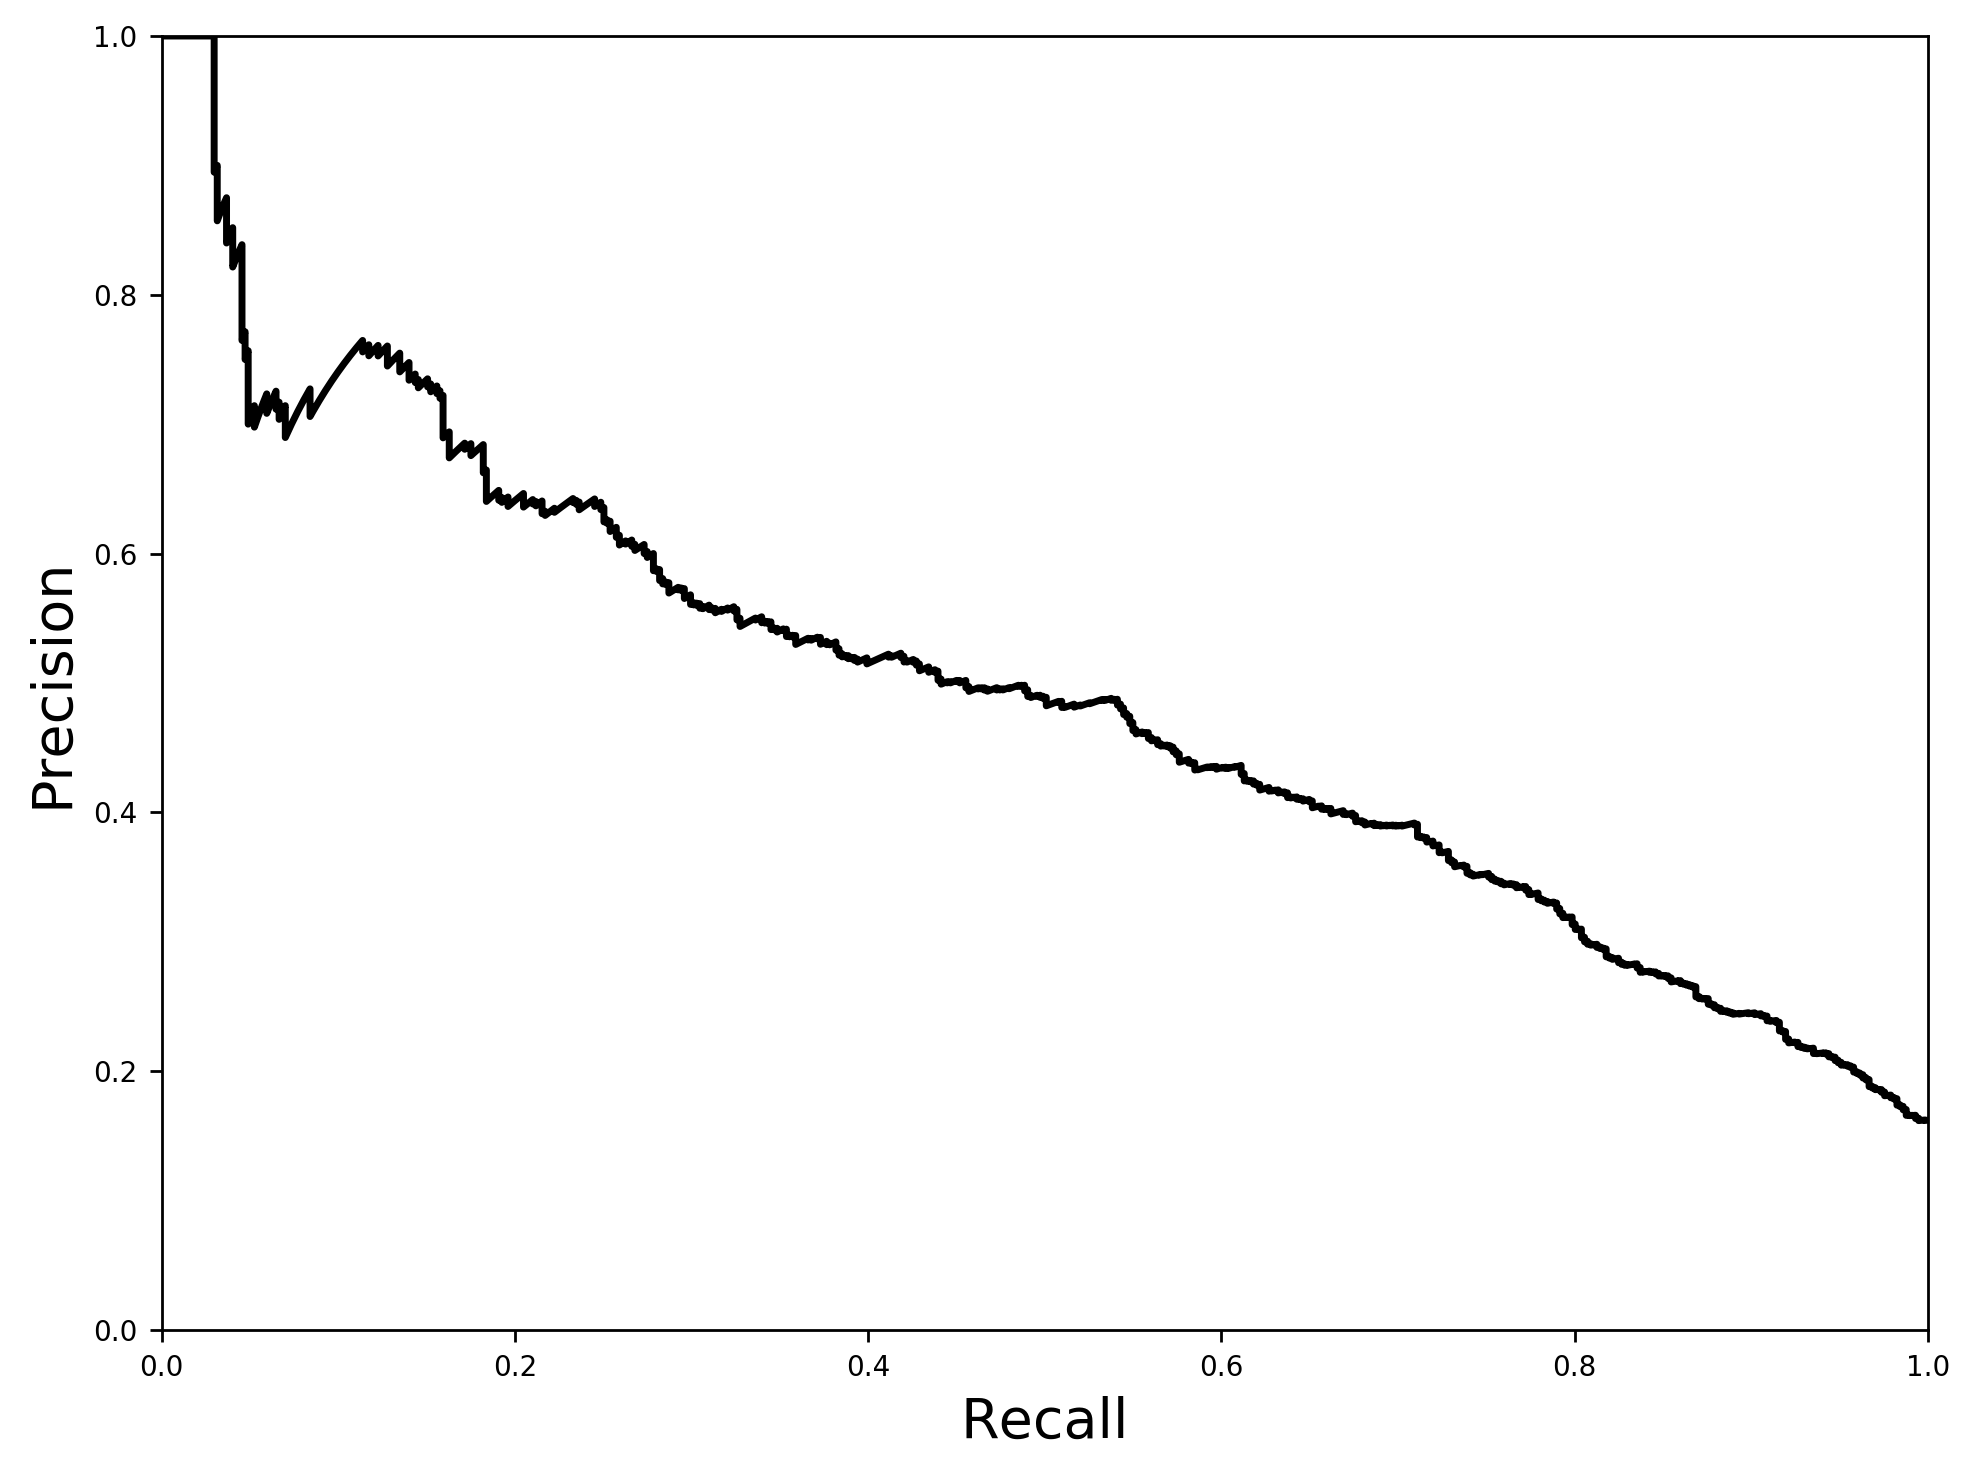

In [41]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "k-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("precision_vs_recall_plot")
plt.show()

Déterminons maintenant la valeur du seuil comprenant le meilleur f1 score

In [42]:
from numpy import argmax
fscore = (2 * precisions * recalls) / (precisions + recalls)
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
logisitc_reg_thresholds = thresholds[ix]

Best Threshold=-0.867101, F-Score=0.513


In [43]:
dataset_train_pred_pvr = (y_scores > logisitc_reg_thresholds)

precision_score(dataset_train_label_true, dataset_train_pred_pvr), recall_score(dataset_train_label_true, dataset_train_pred_pvr), f1_score(dataset_train_label_true, dataset_train_pred_pvr)

(0.48657187993680884, 0.5394045534150613, 0.5116279069767442)

#### Courbe ROC

Affichons la courbe roc afin de confronter notre taux de vrai positif par rapport au taux de faux positif. plus la courbe se rapproche du coin supérieur gauche, plus notre taux de vrai positif est idéal, et on évite un maximum de faux positif. On utilise l'air sous la courbe ROC afin de comparer nos modèles, qui doit être le plus proche de 1.

In [44]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(dataset_train_label_true, y_scores)

Saving figure roc_curve_plot


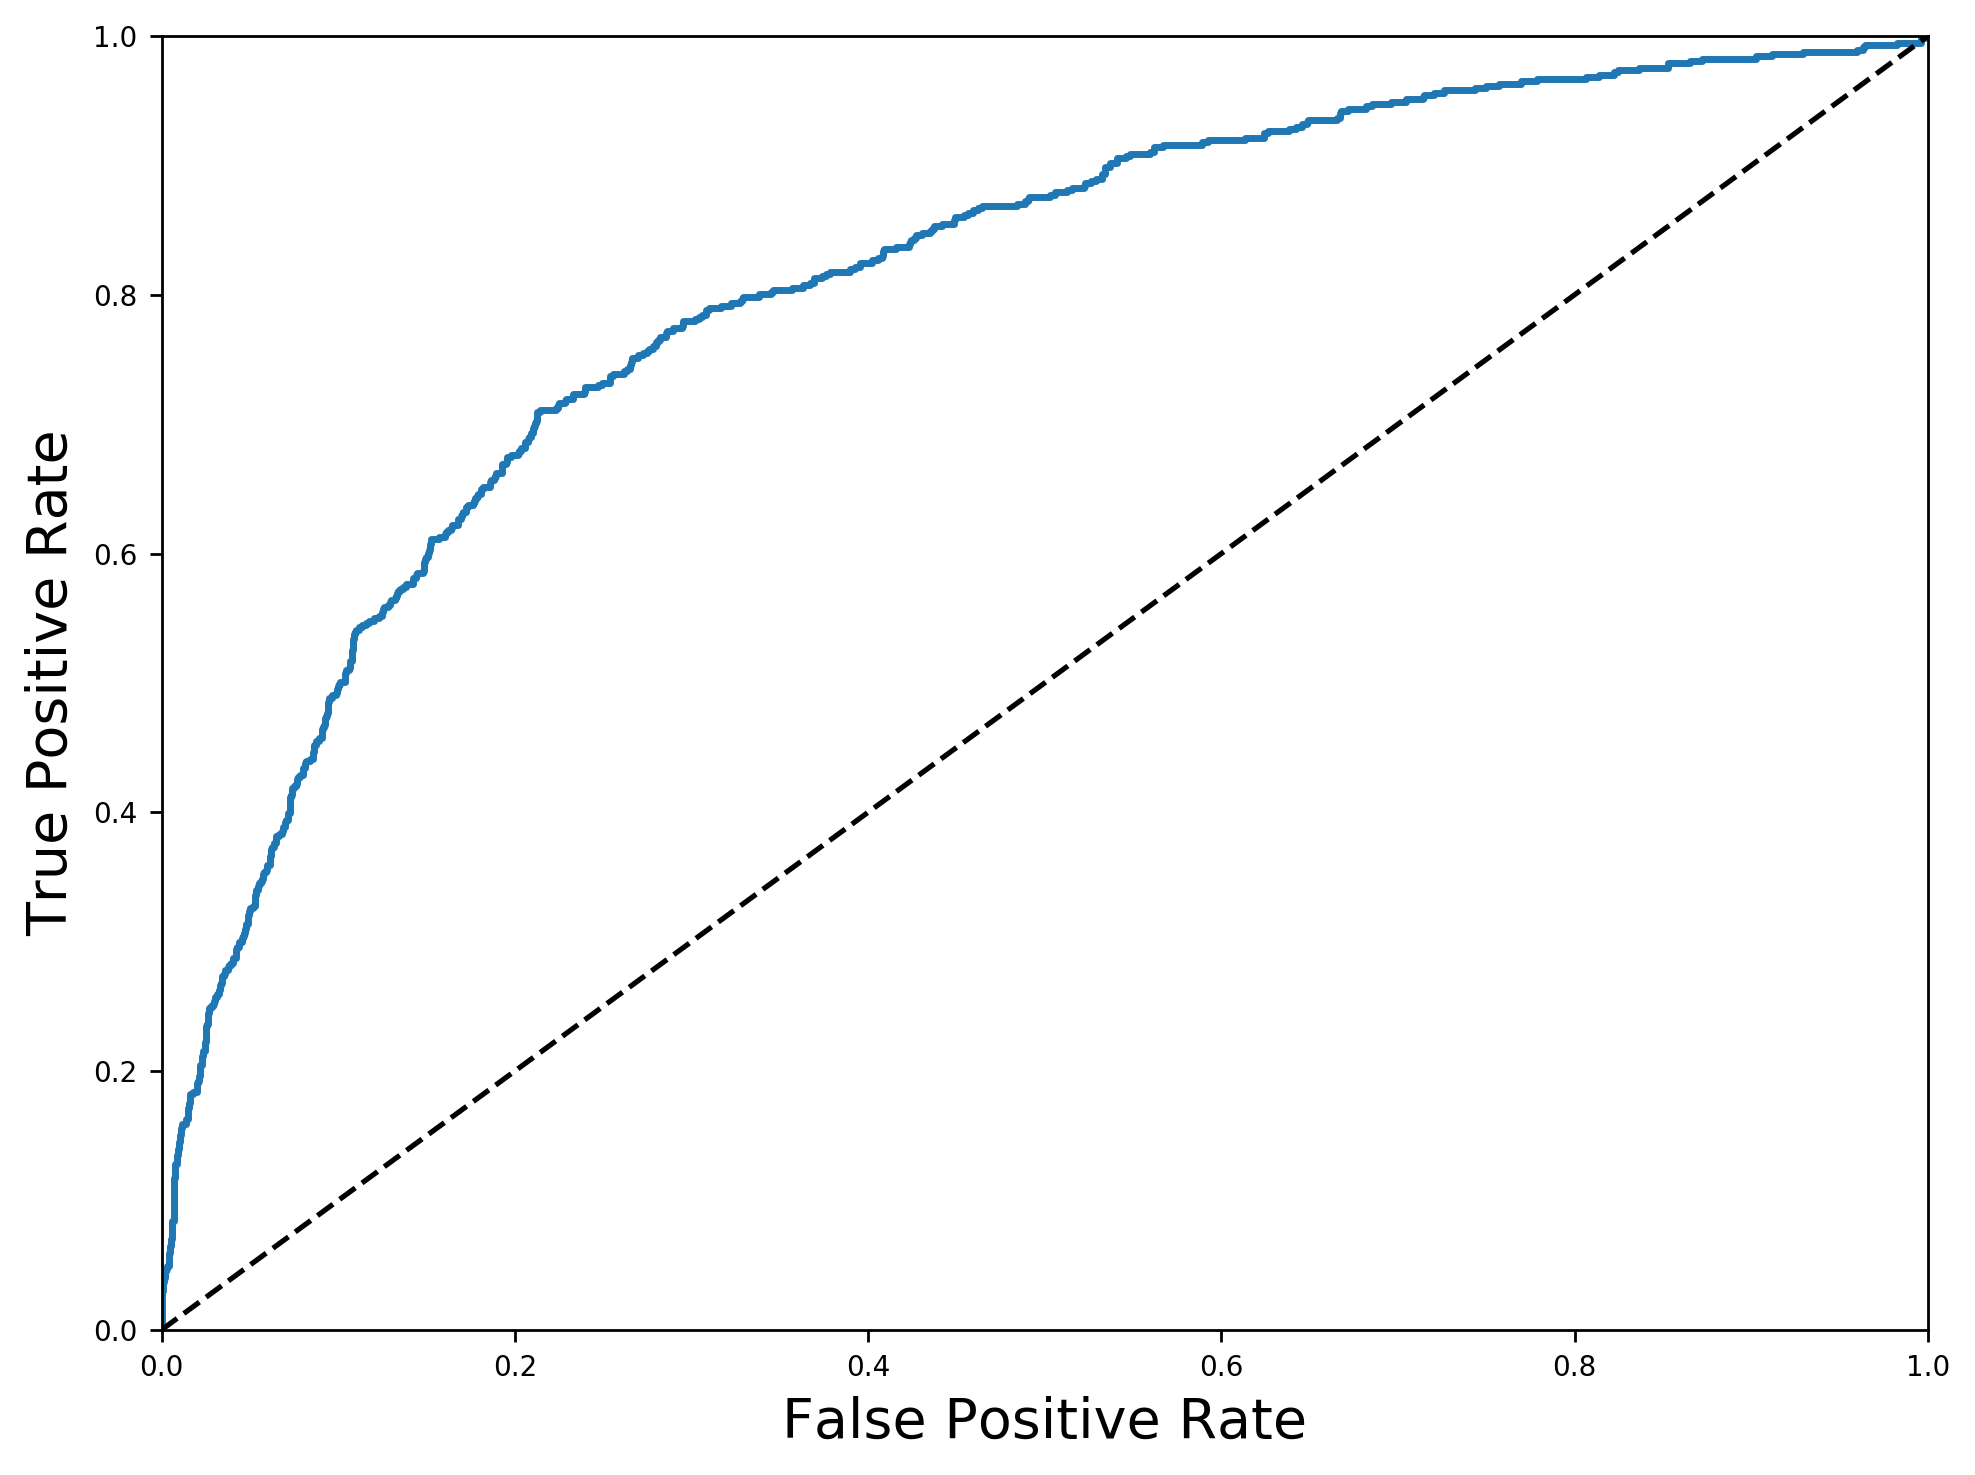

In [45]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
save_fig("roc_curve_plot")
plt.show()

In [46]:
from sklearn.metrics import roc_auc_score
roc_auc_score(dataset_train_label_true, y_scores)

0.8060347763358875

Nous allons nous baser sur cette méthode afin de tester les 3 autres modèles afin d'avoir des résultats concordant nous permettant de choisir correctement le modèle à utiliser pour resoudre notre problème.

### Perceptron

In [47]:
from sklearn.linear_model import Perceptron

perceptron = Perceptron(tol=1e-3, random_state=42)
perceptron.fit(dataset_train_prepared,dataset_train_labels)
perceptron_pred = perceptron.predict(dataset_train_prepared)

In [48]:
perceptron_pred_scores = cross_val_score(perceptron, dataset_train_prepared, dataset_train_labels, 
                                         scoring="f1", cv=7)

display_scores(perceptron_pred_scores)

Scores: [0.25149701 0.28037383 0.27642276 0.30434783 0.390625   0.44444444
 0.3       ]
Mean: 0.32110155321753825
Standard deviation: 0.0646669222844018


#### Paramétrage du modèle (_fine tuning_)

In [49]:
perceptron_param_grid = {'penalty' : ['l1', 'l2', 'elasticnet'],
    'fit_intercept': [True, False],
    'max_iter': [500, 1000, 1500, 2000]
    }

grid_search = GridSearchCV(perceptron, perceptron_param_grid, cv=7,
                           scoring='f1', return_train_score=True)
grid_search.fit(dataset_train_prepared, dataset_train_labels)

GridSearchCV(cv=7, error_score=nan,
             estimator=Perceptron(alpha=0.0001, class_weight=None,
                                  early_stopping=False, eta0=1.0,
                                  fit_intercept=True, max_iter=1000,
                                  n_iter_no_change=5, n_jobs=None, penalty=None,
                                  random_state=42, shuffle=True, tol=0.001,
                                  validation_fraction=0.1, verbose=0,
                                  warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'fit_intercept': [True, False],
                         'max_iter': [500, 1000, 1500, 2000],
                         'penalty': ['l1', 'l2', 'elasticnet']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='f1', verbose=0)

In [50]:
grid_search.best_params_

{'fit_intercept': False, 'max_iter': 500, 'penalty': 'l2'}

In [51]:
best_perceptron = grid_search.best_estimator_

In [52]:
best_perceptron_score = cross_val_score(best_perceptron, dataset_train_prepared, 
                                          dataset_train_labels, cv=7, scoring="f1")

display_scores(best_perceptron_score)

Scores: [0.20183486 0.52571429 0.32       0.36477987 0.38918919 0.49411765
 0.23357664]
Mean: 0.3613160715567461
Standard deviation: 0.11270097953357129


#### Matrice de Confusion

In [53]:
best_perceptron_pred = cross_val_predict(best_perceptron, dataset_train_prepared, dataset_train_label_true, cv=7)

In [54]:
confusion_matrix(dataset_train_label_true, best_perceptron_pred)

array([[2668,  289],
       [ 371,  200]], dtype=int64)

In [55]:
precision_score(dataset_train_label_true, best_perceptron_pred)

0.40899795501022496

In [56]:
recall_score(dataset_train_label_true, best_perceptron_pred)

0.3502626970227671

In [57]:
f1_score(dataset_train_label_true, best_perceptron_pred)

0.3773584905660377

#### Recall et precision en fonction du seuil

In [58]:
y_scores_perceptron = cross_val_predict(best_perceptron, dataset_train_prepared, dataset_train_label_true, cv=7,
                             method="decision_function")

Saving figure precision_recall_vs_threshold_plot


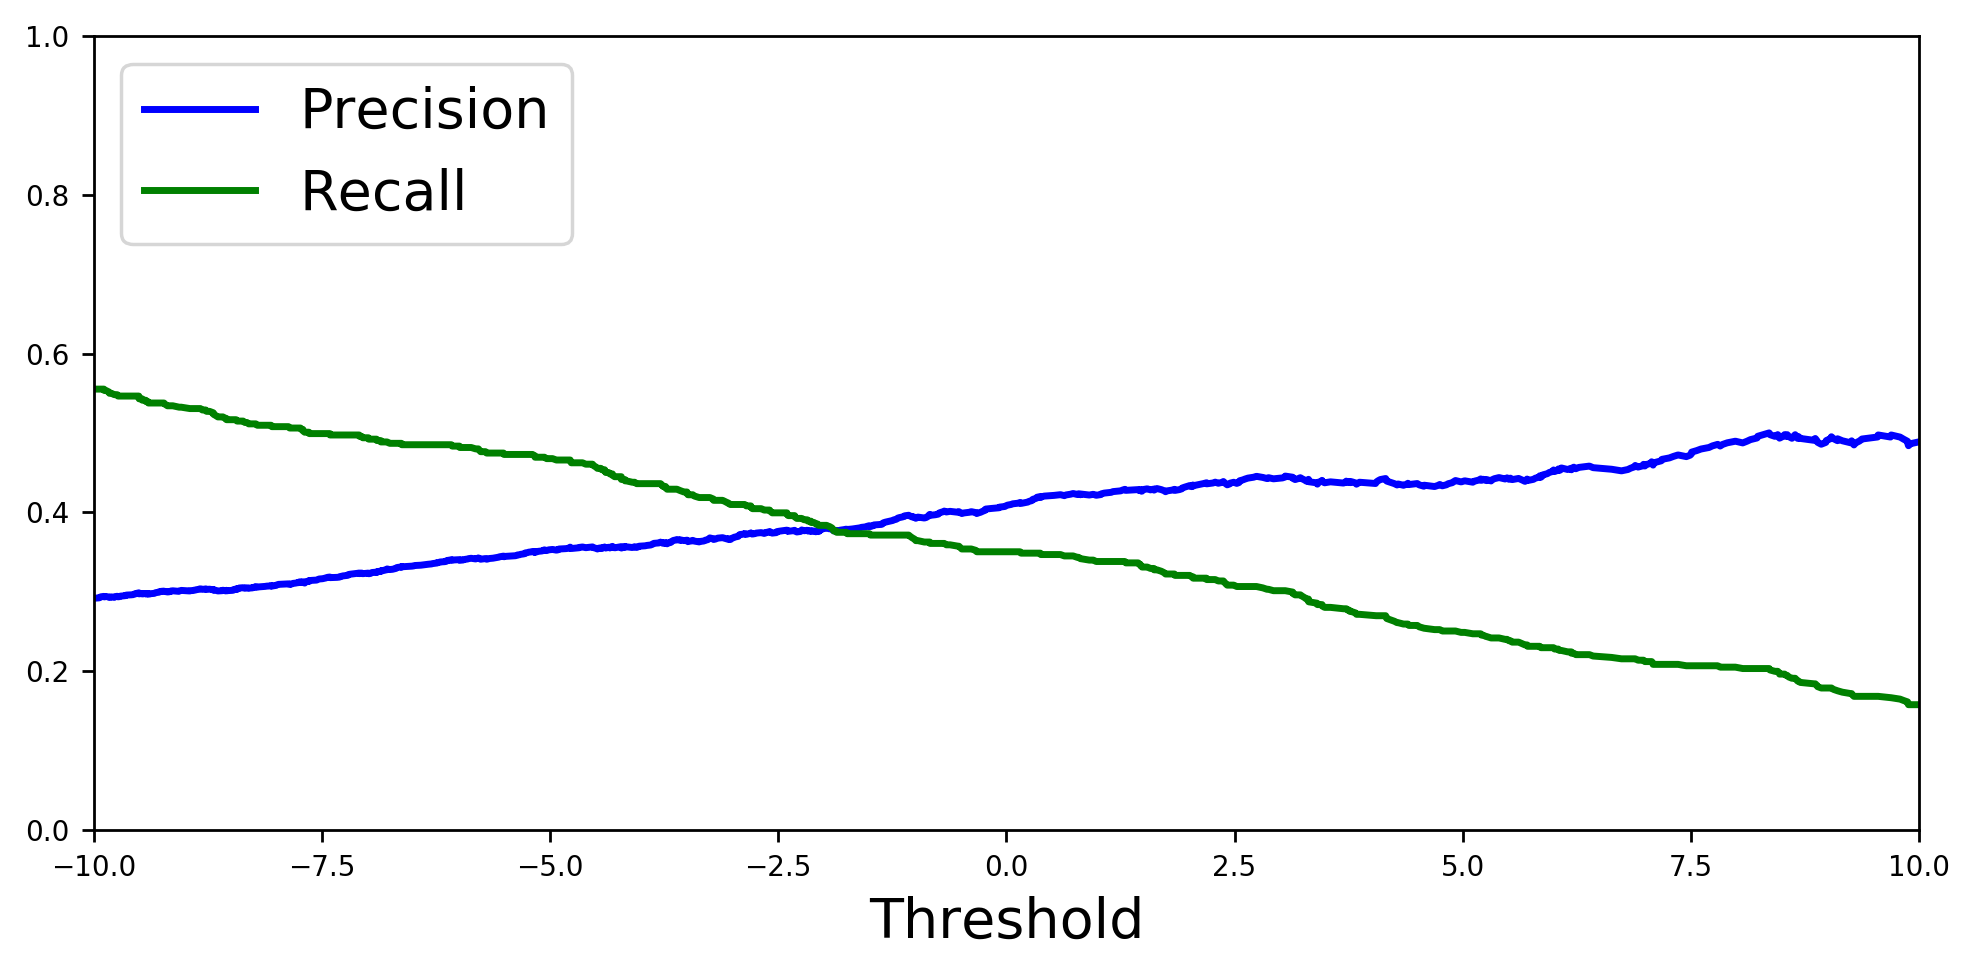

In [59]:
precisions, recalls, thresholds = precision_recall_curve(dataset_train_label_true, y_scores_perceptron)

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-10, 10])
save_fig("precision_recall_vs_threshold_plot")
plt.show()

Saving figure precision_vs_recall_plot


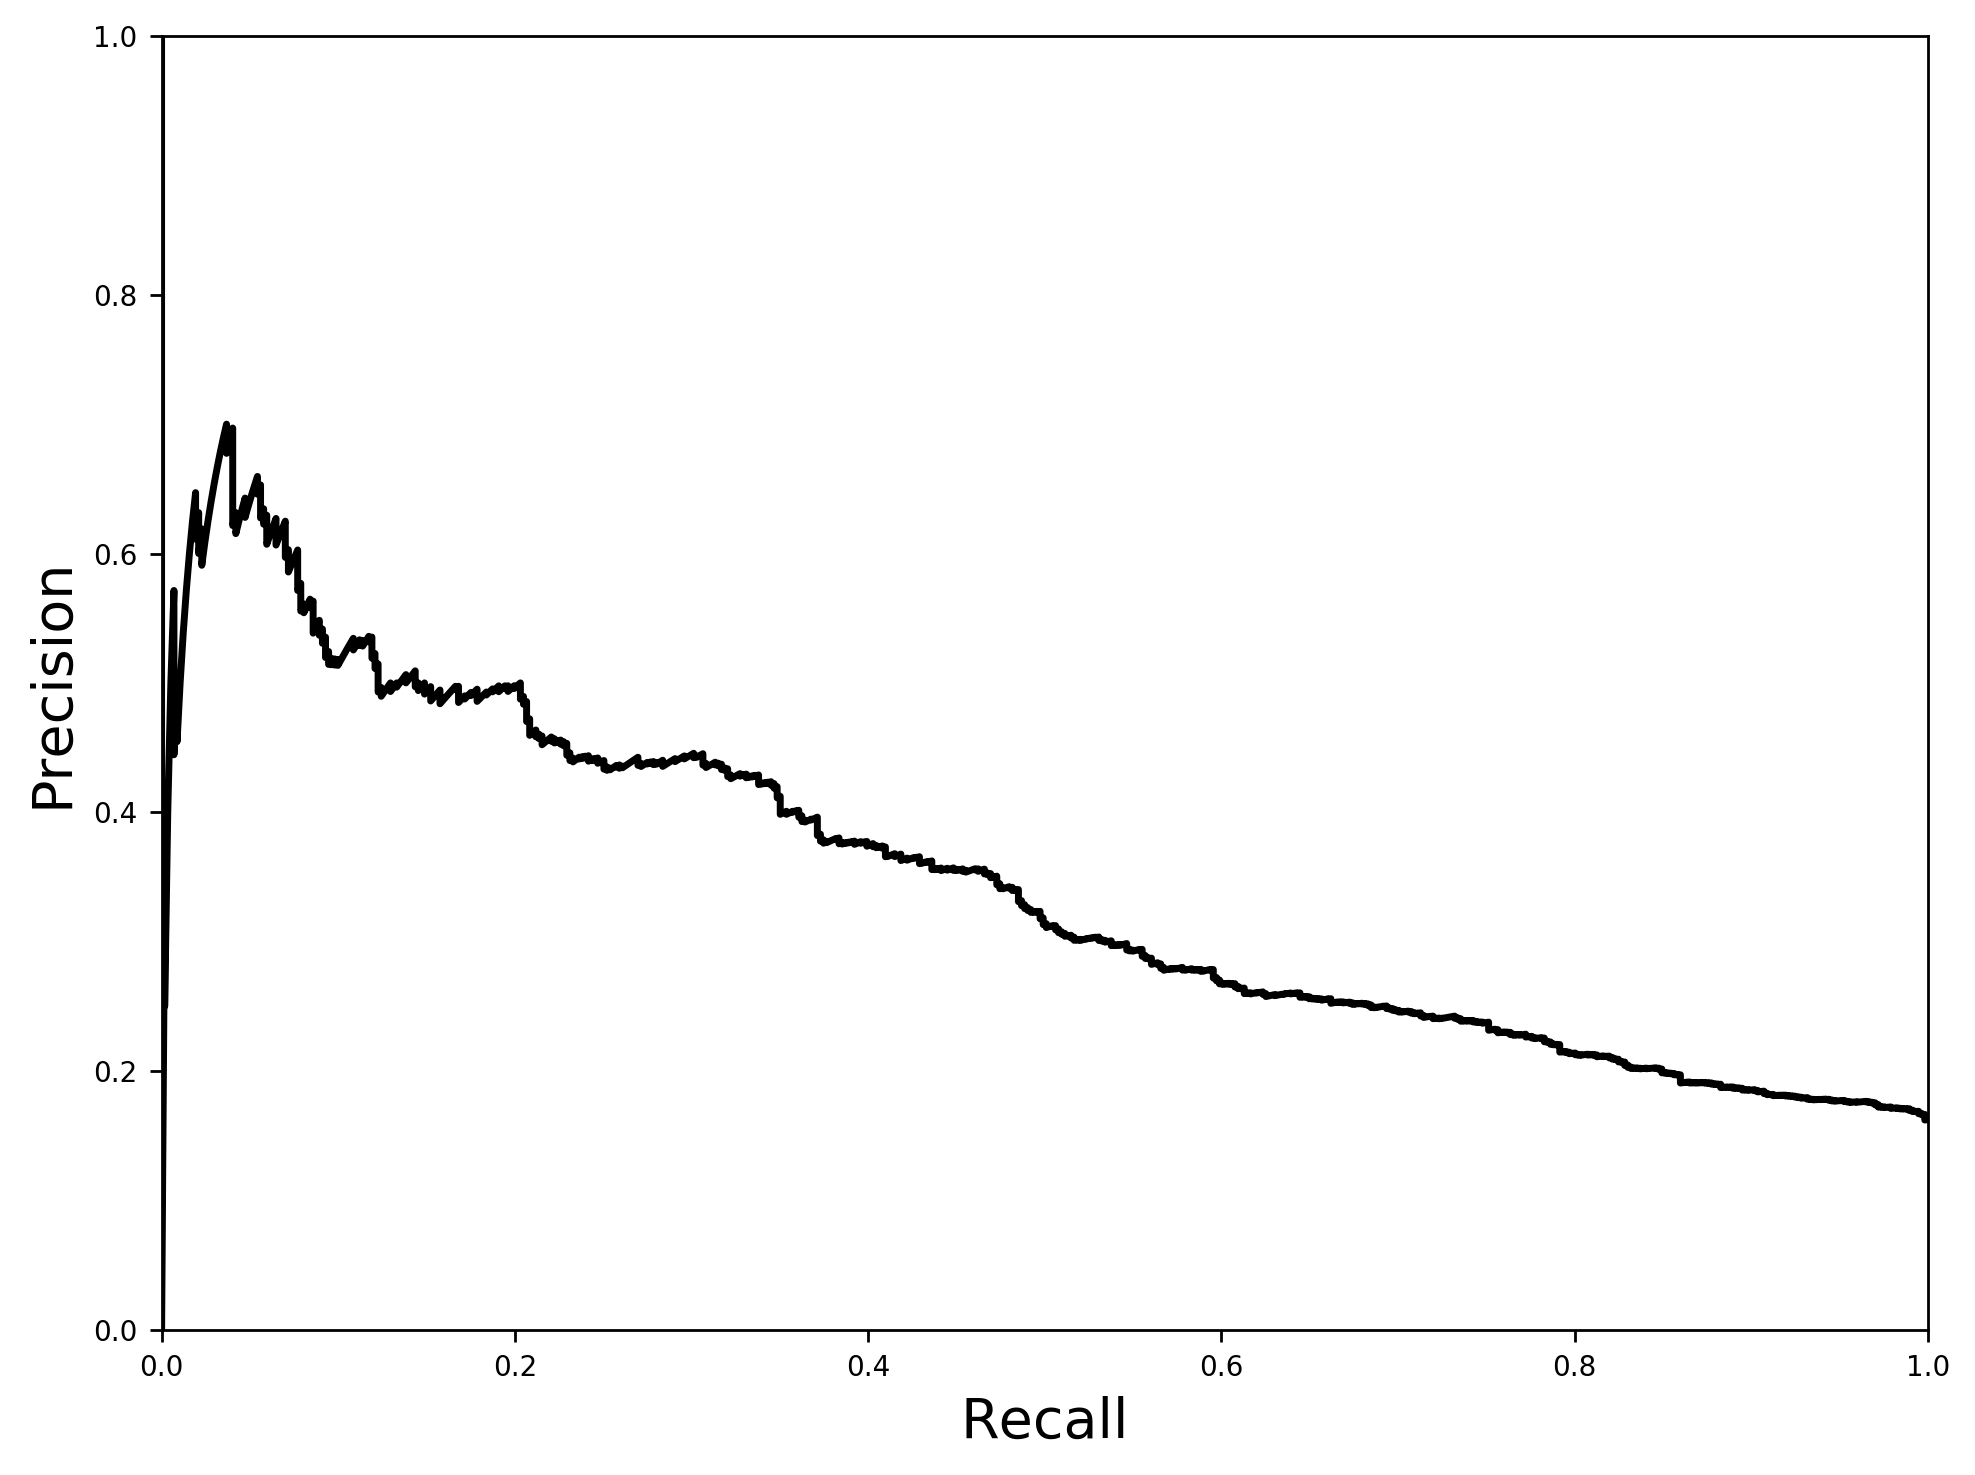

In [60]:
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("precision_vs_recall_plot")
plt.show()

In [61]:
fscore = (2 * precisions * recalls) / (precisions + recalls)
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
perceptron_thresholds = thresholds[ix]

Best Threshold=37.442334, F-Score=nan


In [62]:
dataset_train_pred_pvr = (y_scores_perceptron > perceptron_thresholds)

precision_score(dataset_train_label_true, dataset_train_pred_pvr), recall_score(dataset_train_label_true, dataset_train_pred_pvr), f1_score(dataset_train_label_true, dataset_train_pred_pvr)

(0.0, 0.0, 0.0)

#### Courbe ROC

Saving figure roc_curve_comparison_plot


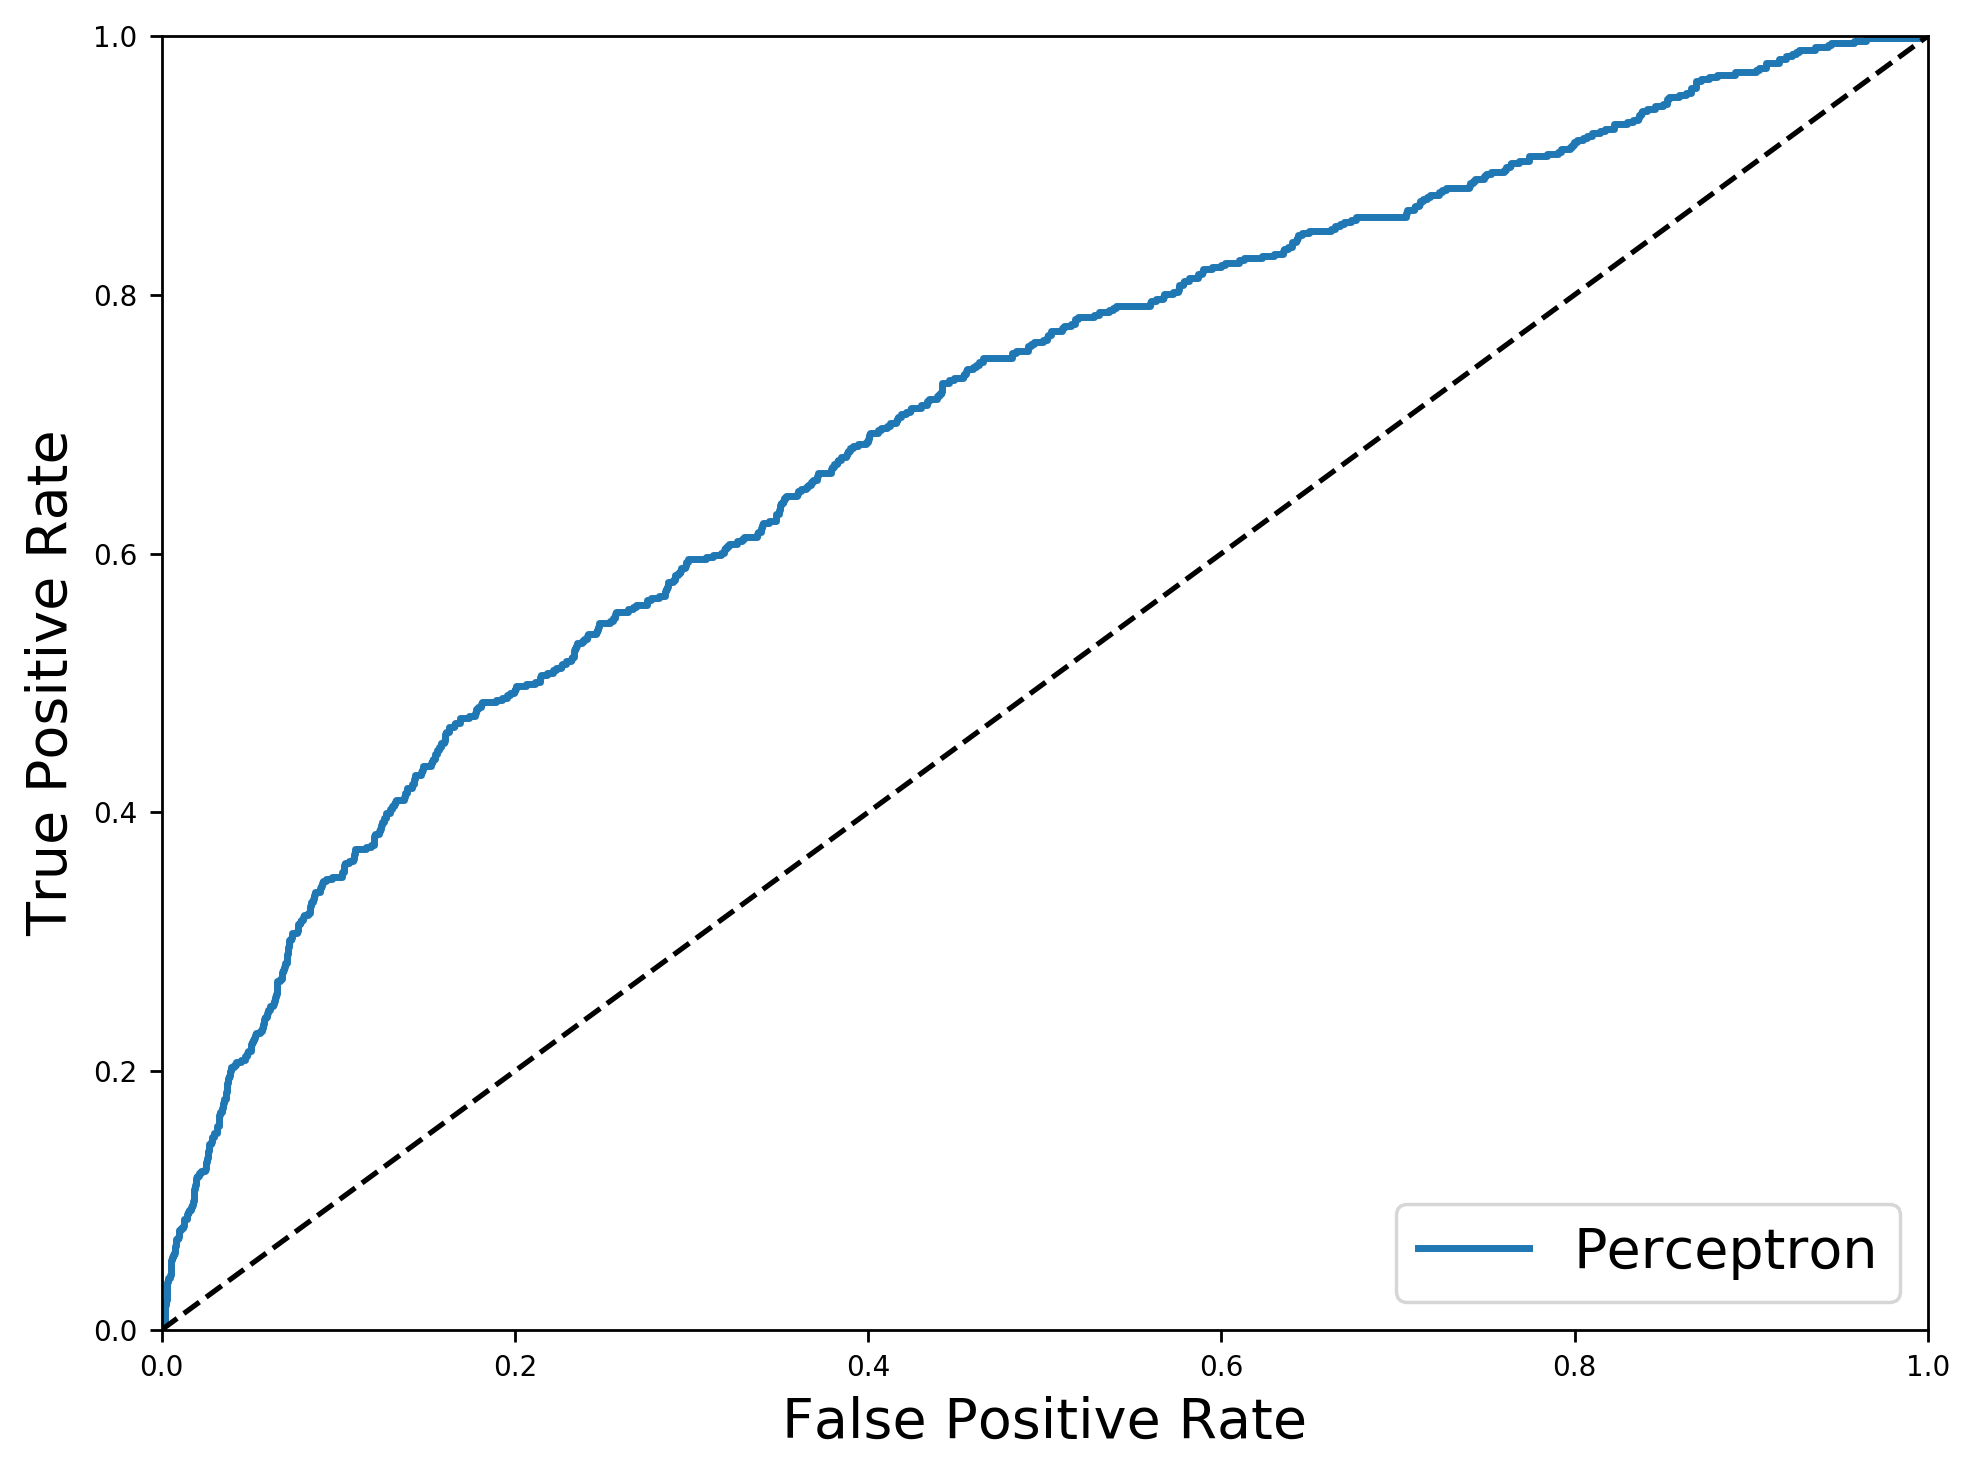

In [63]:
fpr_percep, tpr_percep, thresholds_percep = roc_curve(dataset_train_label_true, y_scores_perceptron)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_percep, tpr_percep, "Perceptron")
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [64]:
roc_auc_score(dataset_train_label_true, y_scores_perceptron)

0.7020392111804516

### Random Forest Classifier

In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict

forest_clf = RandomForestClassifier(random_state=42, n_estimators=10)
y_probas_forest = cross_val_predict(forest_clf, dataset_train_prepared, dataset_train_label_true, cv=7,
                                    method="predict")

In [66]:
precision_score(dataset_train_label_true, y_probas_forest)

0.9800443458980045

In [67]:
recall_score(dataset_train_label_true, y_probas_forest)

0.7740805604203153

In [68]:
f1_score(dataset_train_label_true, y_probas_forest)

0.8649706457925637

In [69]:
forest_score = cross_val_score(forest_clf, dataset_train_prepared, dataset_train_label_true, cv=7, scoring="f1")
display_scores(forest_score)

Scores: [0.83098592 0.92207792 0.875      0.87671233 0.83333333 0.88435374
 0.82758621]
Mean: 0.8642927782949267
Standard deviation: 0.03257005996537404


#### Paramétrage du modèle (_fine tuning_)

In [70]:
forest_clf_param_grid = [
    {'n_estimators' : [50, 100, 200, 300],
    'max_depth' : [10, 20, 40, 50]}
  ]

grid_search = GridSearchCV(forest_clf, forest_clf_param_grid, cv=7,
                           scoring='f1', return_train_score=True)
grid_search.fit(dataset_train_prepared, dataset_train_labels)

GridSearchCV(cv=7, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=None,
                                              oob_score=False, random_state=42,
                                   

In [71]:
grid_search.best_params_

{'max_depth': 40, 'n_estimators': 300}

In [72]:
best_forest_clf = grid_search.best_estimator_

In [73]:
best_forest_clf_score = cross_val_score(best_forest_clf, dataset_train_prepared, 
                                          dataset_train_labels, cv=7, scoring="f1")

display_scores(best_forest_clf_score)

Scores: [0.90066225 0.96815287 0.94805195 0.95541401 0.94193548 0.95541401
 0.92105263]
Mean: 0.9415261724110341
Standard deviation: 0.021469261147729873


#### Matrice de Confusion

In [74]:
best_forest_clf_pred = cross_val_predict(best_forest_clf, dataset_train_prepared, dataset_train_label_true, cv=7)

In [75]:
confusion_matrix(dataset_train_label_true, best_forest_clf_pred)

array([[2955,    2],
       [  61,  510]], dtype=int64)

In [76]:
precision_score(dataset_train_label_true, best_forest_clf_pred)

0.99609375

In [77]:
recall_score(dataset_train_label_true, best_forest_clf_pred)

0.8931698774080561

In [78]:
f1_score(dataset_train_label_true, best_forest_clf_pred)

0.9418282548476454

#### Recall et precision en fonction du seuil

In [79]:
y_scores_forest_clf = cross_val_predict(best_forest_clf, dataset_train_prepared, dataset_train_label_true, cv=7,
                             method="predict_proba")
y_scores_forest_clf = y_scores_forest_clf[:,1]

Saving figure precision_recall_vs_threshold_plot


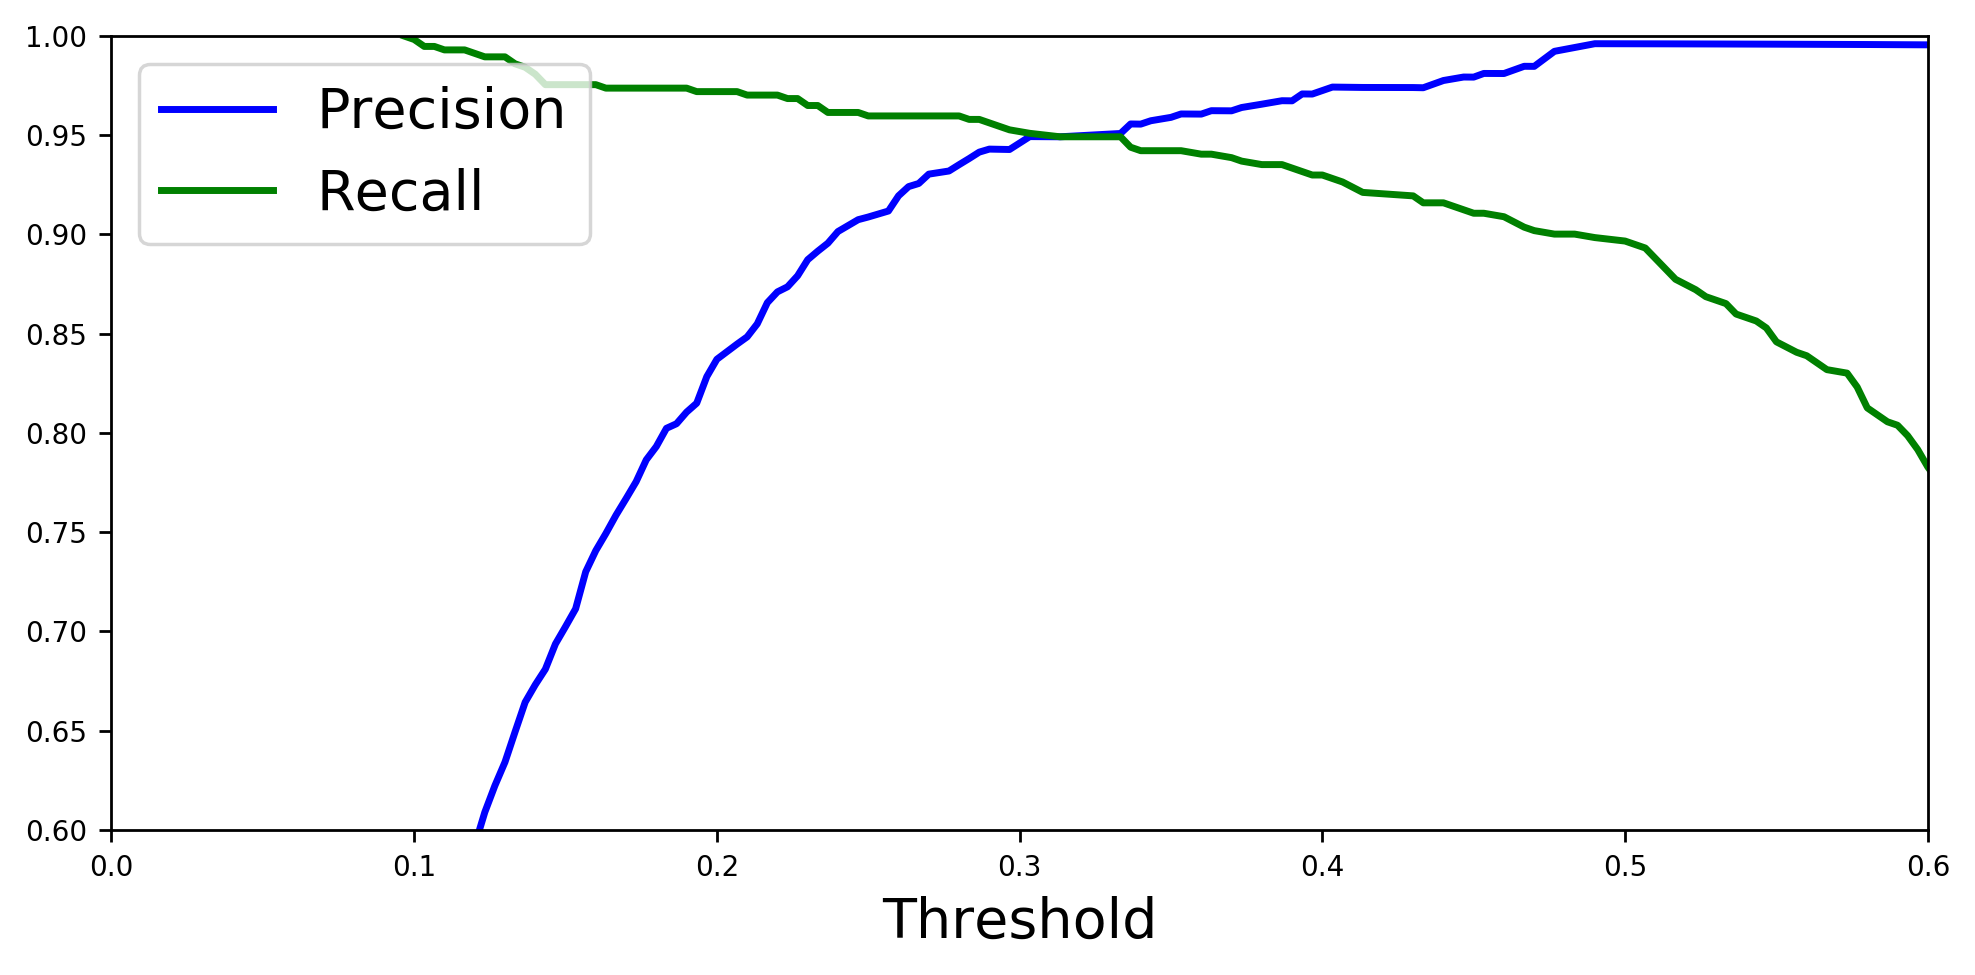

In [80]:
precisions, recalls, thresholds = precision_recall_curve(dataset_train_label_true, y_scores_forest_clf)

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([0, 0.6])
plt.ylim([0.6, 1])
save_fig("precision_recall_vs_threshold_plot")
plt.show()

Saving figure precision_vs_recall_plot


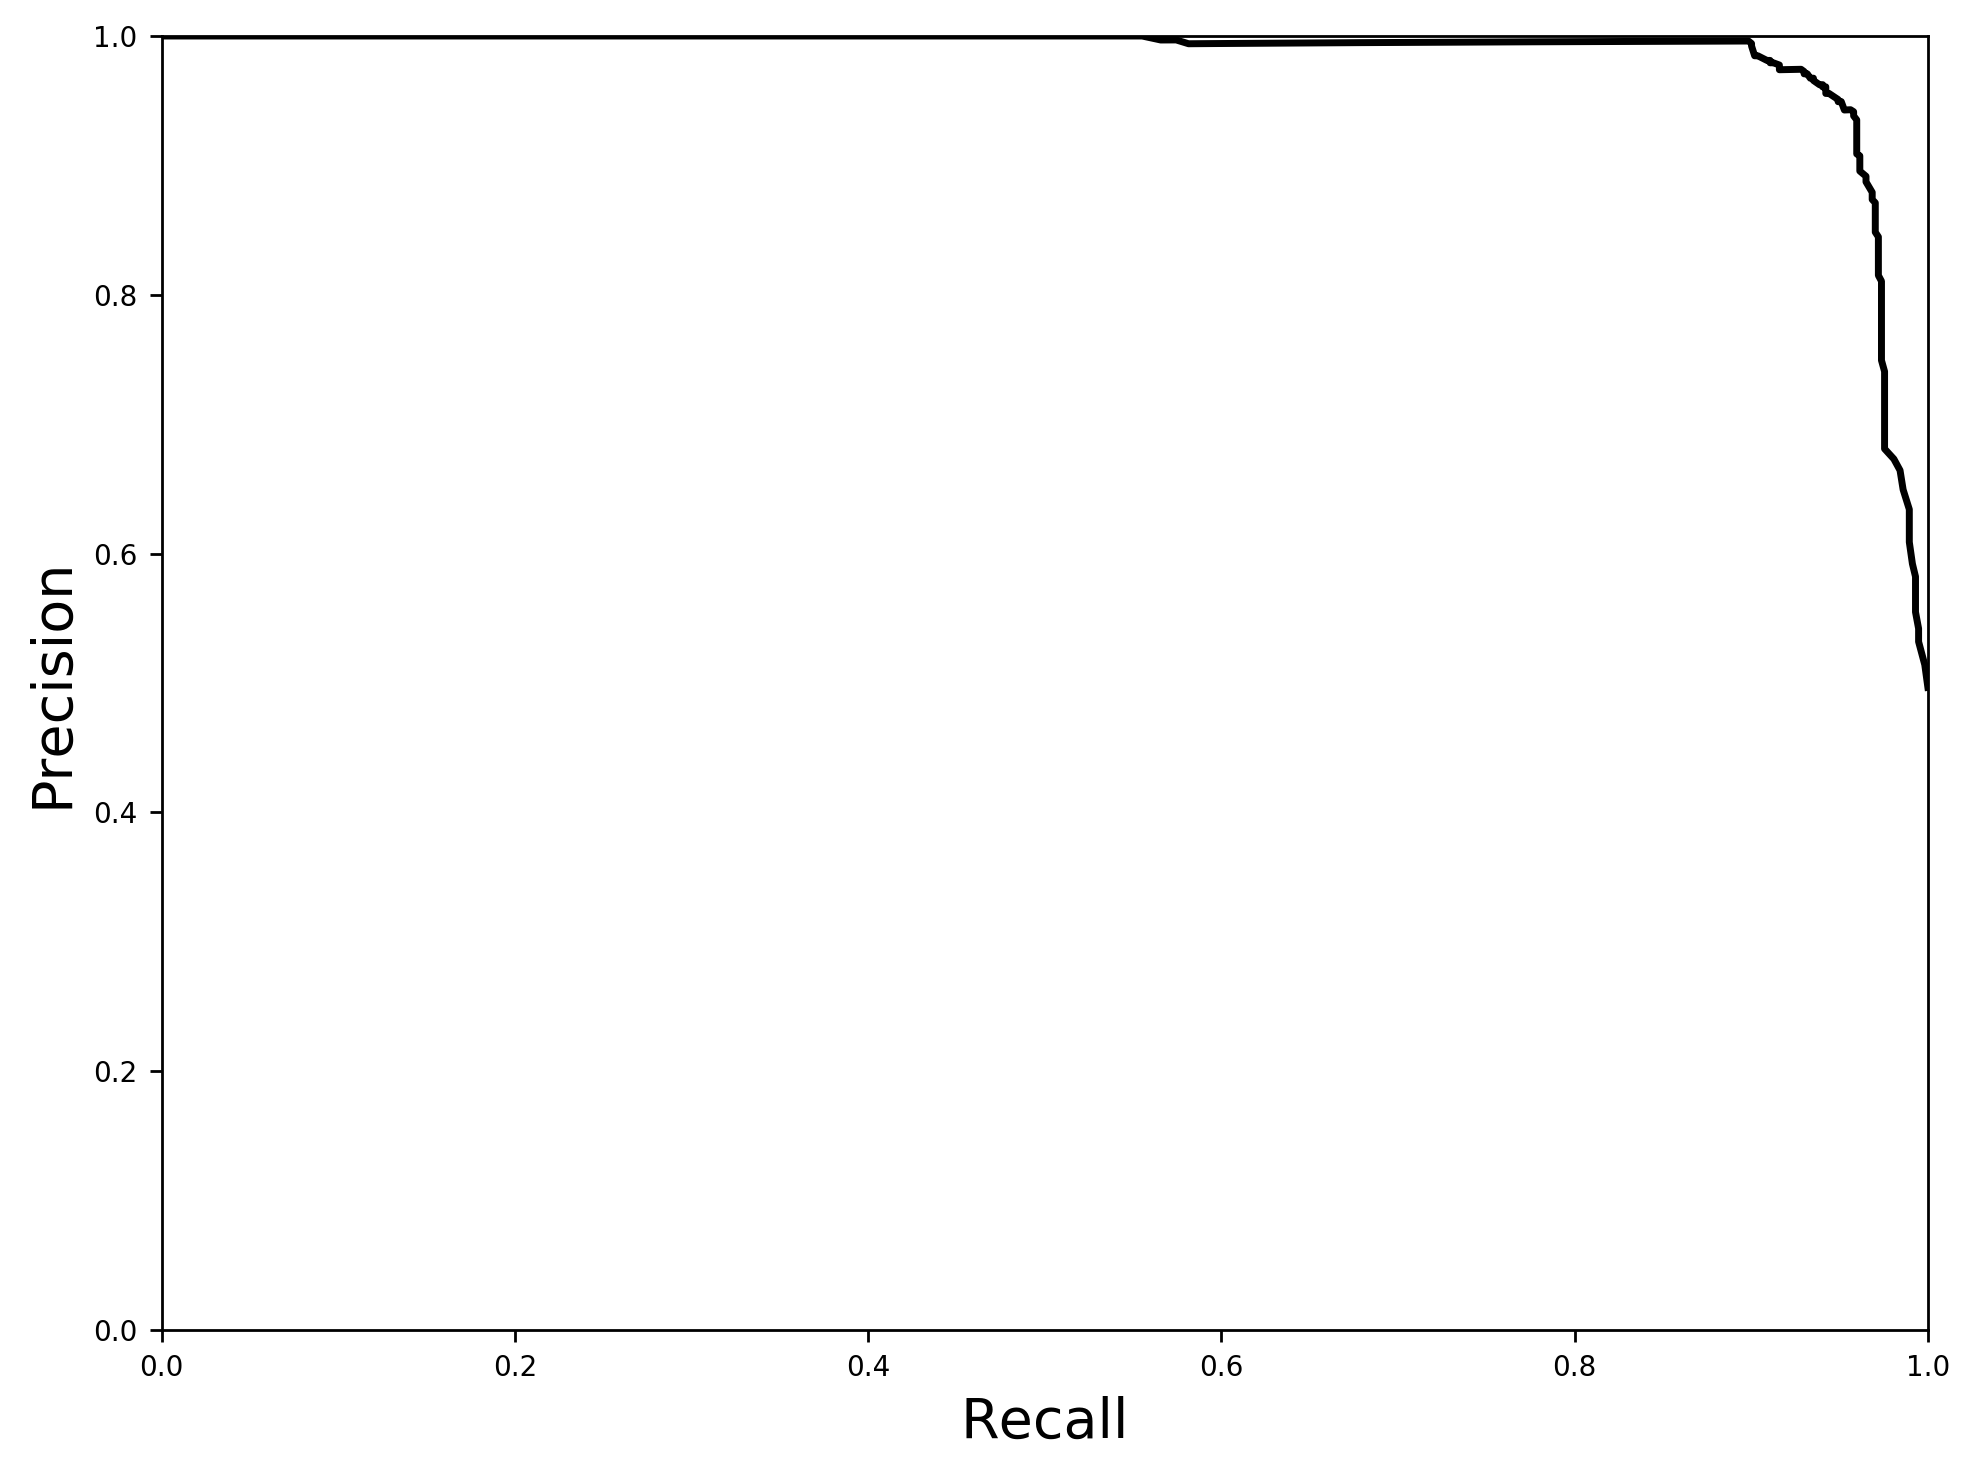

In [81]:
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("precision_vs_recall_plot")
plt.show()

In [82]:
fscore = (2 * precisions * recalls) / (precisions + recalls)
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
forest_thresholds = thresholds[ix]

Best Threshold=0.353333, F-Score=0.951


In [83]:
dataset_train_pred_pvr = (y_scores_forest_clf > thresholds[ix])

precision_score(dataset_train_label_true, dataset_train_pred_pvr), recall_score(dataset_train_label_true, dataset_train_pred_pvr), f1_score(dataset_train_label_true, dataset_train_pred_pvr)

(0.960644007155635, 0.9404553415061296, 0.9504424778761061)

#### Courbe ROC

Saving figure roc_curve_comparison_plot


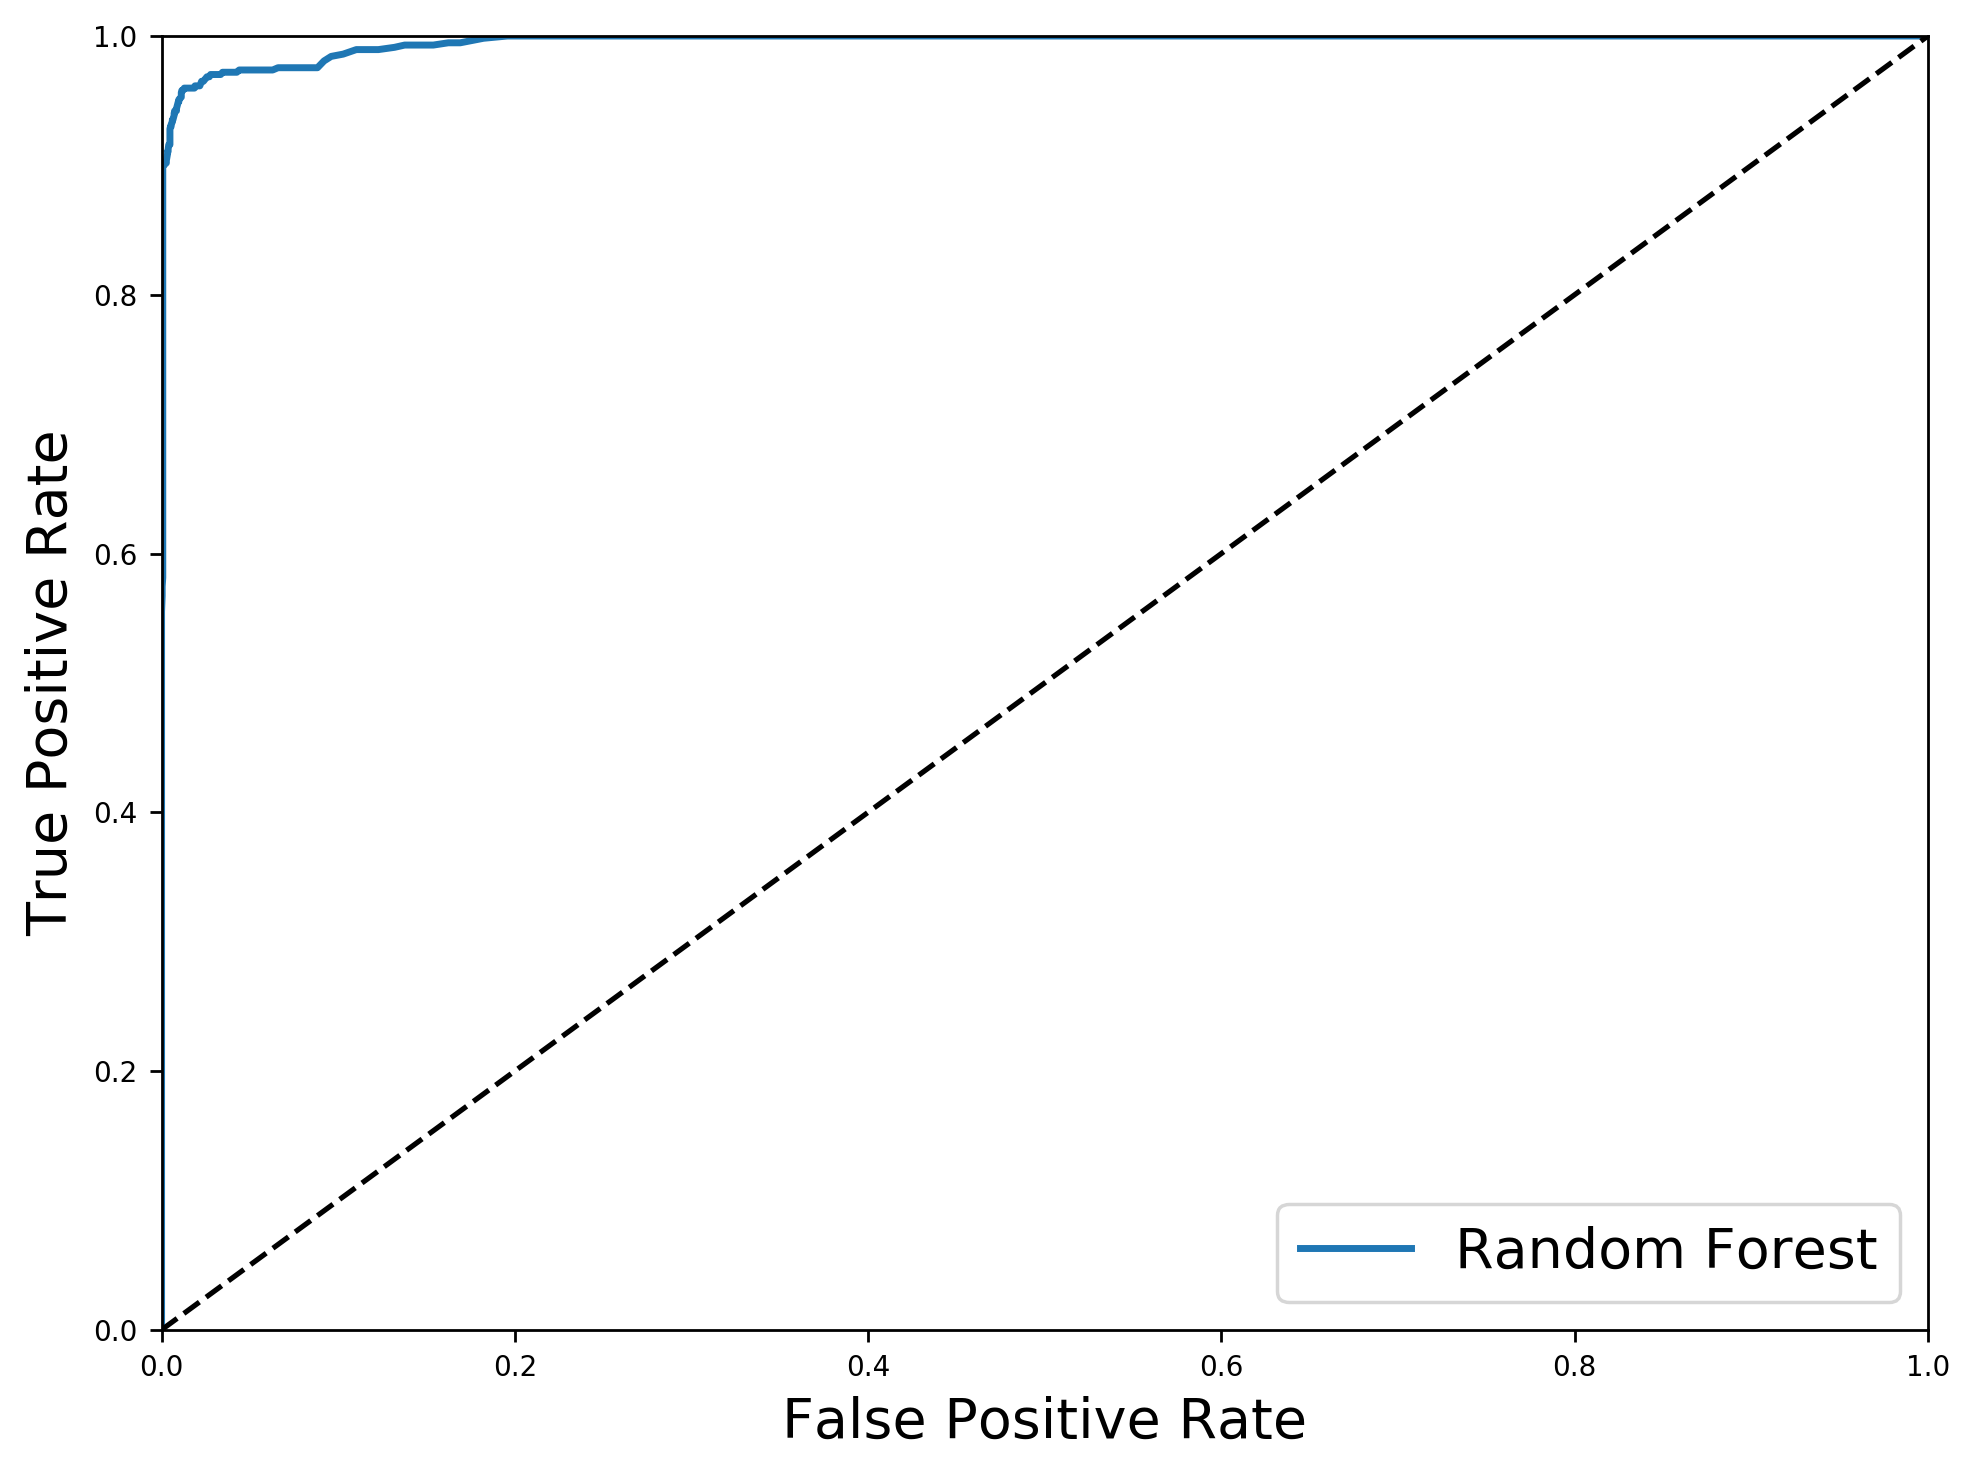

In [84]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(dataset_train_label_true, y_scores_forest_clf)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

roc_auc_score(dataset_train_label_true, y_scores_forest_clf)

### Descente de Gradient Stochastique

In [85]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=100, random_state=42)
sgd_clf.fit(dataset_train_prepared, dataset_train_label_true)
sgd_clf_pred = cross_val_predict(sgd_clf, dataset_train_prepared, dataset_train_label_true, cv=7,
                                    method="predict")

In [86]:
sgd_clf_pred_score = cross_val_score(sgd_clf, dataset_train_prepared, dataset_train_label_true, cv=7, scoring="f1")

display_scores(sgd_clf_pred_score)

Scores: [0.34146341 0.18556701 0.32142857 0.47058824 0.37086093 0.39766082
 0.375     ]
Mean: 0.35179556821884034
Standard deviation: 0.08086858287704486


#### Paramétrage du modèle (_fine tuning_)

In [87]:
sgd_clf_param_grid = [
    {'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
    'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'], 
     'penalty': ['l1', 'l2', 'elasticnet']}
  ]

grid_search = GridSearchCV(sgd_clf, sgd_clf_param_grid, cv=7,
                           scoring='f1', return_train_score=True)
grid_search.fit(dataset_train_prepared, dataset_train_labels)

GridSearchCV(cv=7, error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=100,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5, random_state=42,
                                     shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0,
                                    1000.0],
                          'loss': ['hinge', 'log', 'modified_huber',
                  

In [88]:
grid_search.best_params_

{'alpha': 0.1, 'loss': 'squared_hinge', 'penalty': 'l1'}

In [89]:
best_sgd_clf = grid_search.best_estimator_

In [90]:
best_sgd_clf_score = cross_val_score(best_sgd_clf, dataset_train_prepared, 
                                          dataset_train_labels, cv=7, scoring="f1")

display_scores(best_sgd_clf_score)

Scores: [0.34170854 0.44102564 0.42307692 0.33484163 0.42051282 0.4278607
 0.37810945]
Mean: 0.3953051007917085
Standard deviation: 0.04032200858591378


#### Matrice de Confusion

In [91]:
best_sgd_clf_pred = cross_val_predict(best_sgd_clf, dataset_train_prepared, dataset_train_label_true, cv=7)

In [92]:
confusion_matrix(dataset_train_label_true, best_sgd_clf_pred)

array([[2388,  569],
       [ 291,  280]], dtype=int64)

In [93]:
sgd_clf_precision = cross_val_score(best_sgd_clf, dataset_train_prepared, 
                                          dataset_train_labels, cv=7, scoring="precision")
display_scores(sgd_clf_precision)

Scores: [0.28813559 0.37719298 0.34645669 0.26618705 0.36283186 0.36134454
 0.31932773]
Mean: 0.33163949232345996
Standard deviation: 0.03868963350812061


#### Recall et precision en fonction du seuil

In [94]:
y_scores_sgd_clf = cross_val_predict(best_sgd_clf, dataset_train_prepared, dataset_train_label_true, cv=7,
                             method="decision_function")

Saving figure precision_recall_vs_threshold_plot


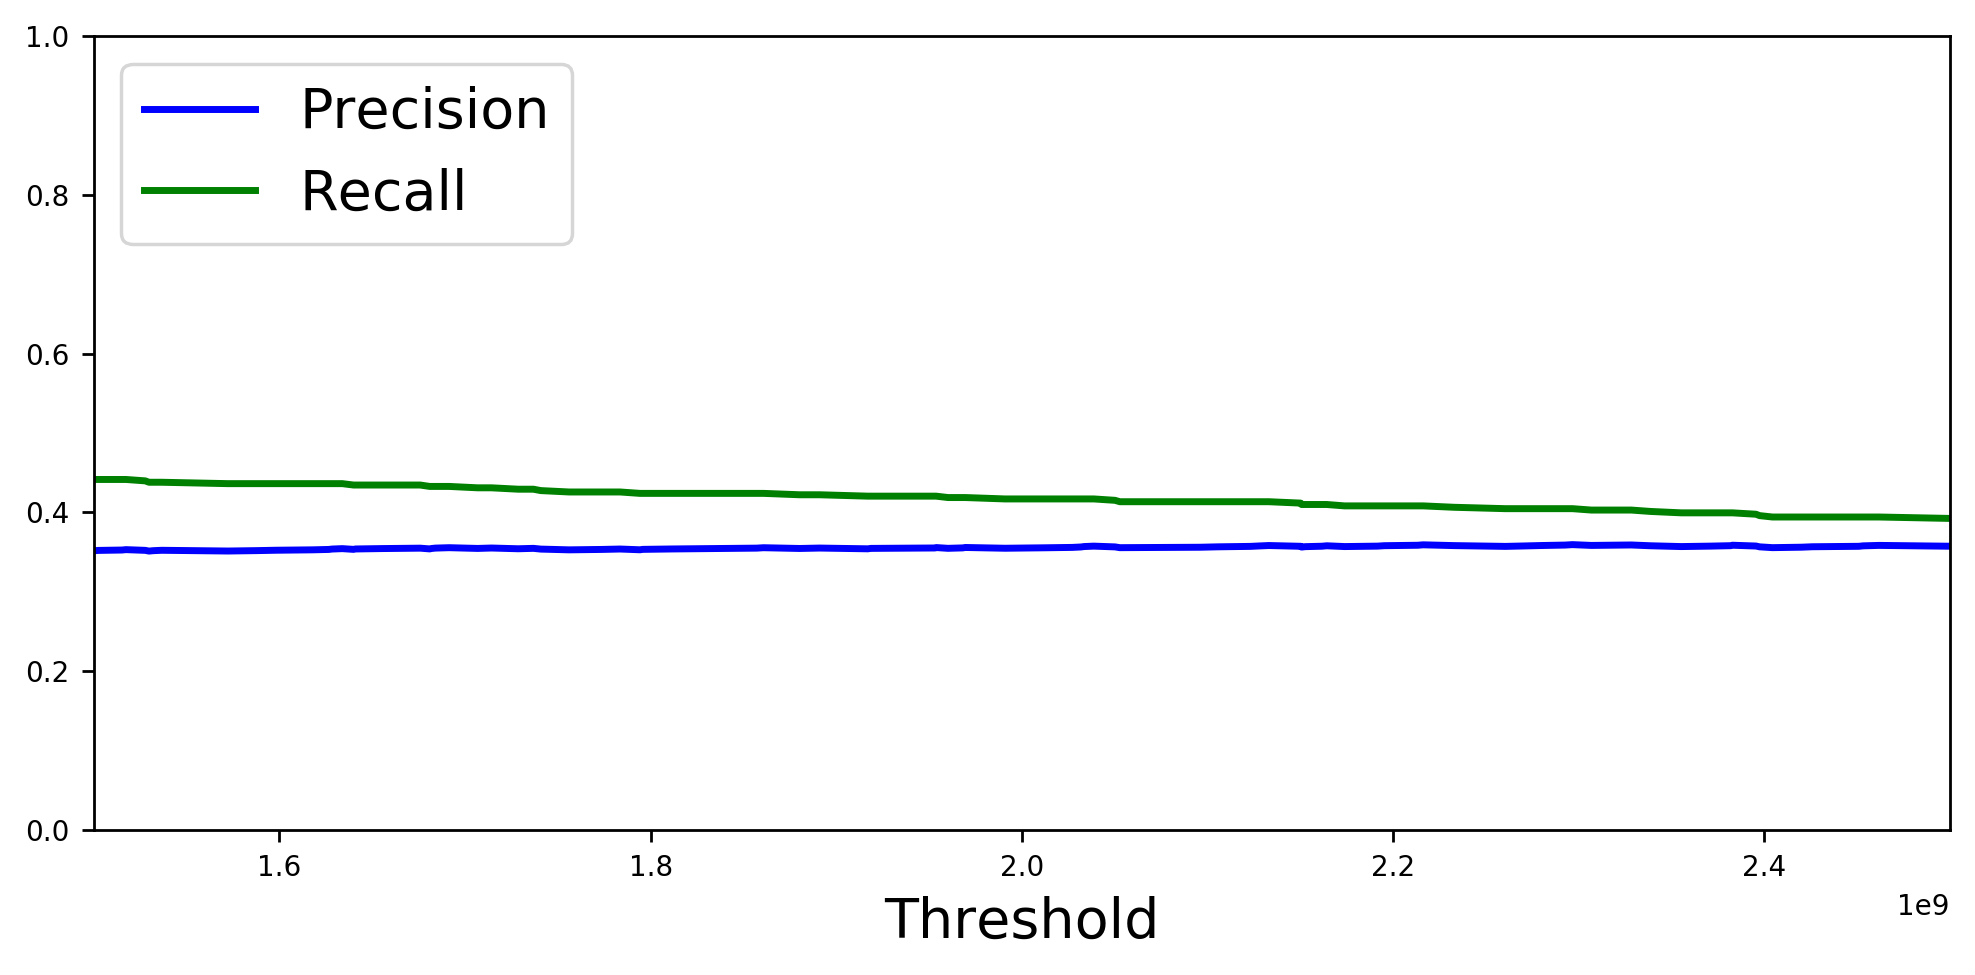

In [95]:
precisions, recalls, thresholds = precision_recall_curve(dataset_train_label_true, y_scores_sgd_clf)

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([1.5e9, 2.5e9])
save_fig("precision_recall_vs_threshold_plot")
plt.show()

Saving figure precision_vs_recall_plot


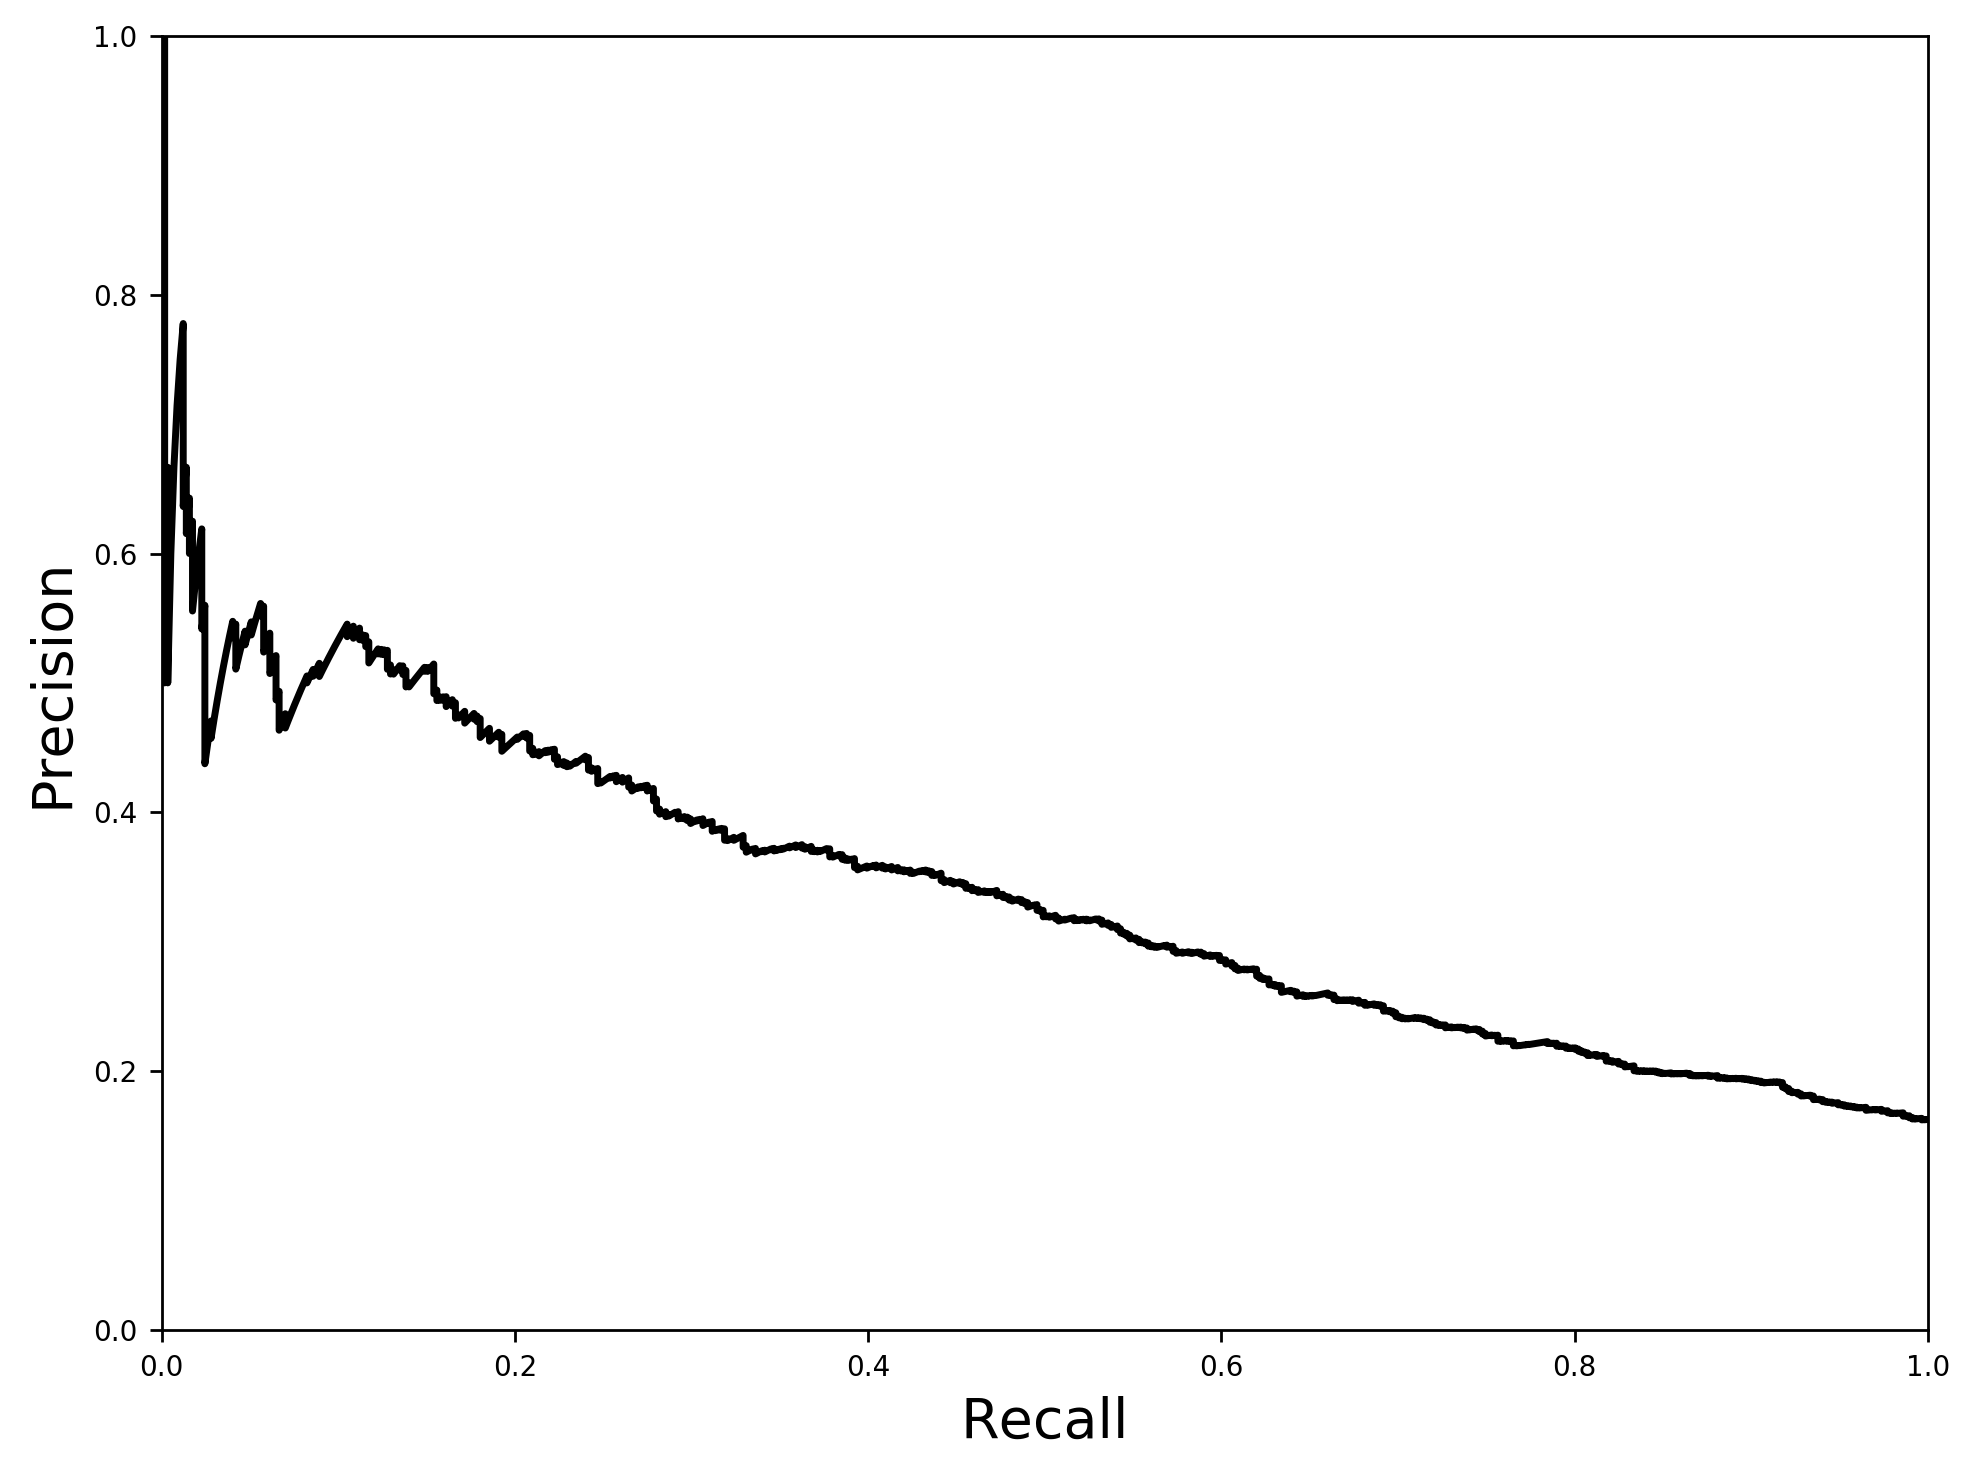

In [96]:
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("precision_vs_recall_plot")
plt.show()

In [97]:
fscore = (2 * precisions * recalls) / (precisions + recalls)
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
sgd_clf_thresholds = thresholds[ix]

Best Threshold=-1009573658.059048, F-Score=0.397


In [98]:
dataset_train_pred_pvr = (y_scores_sgd_clf > sgd_clf_thresholds)

precision_score(dataset_train_label_true, dataset_train_pred_pvr), recall_score(dataset_train_label_true, dataset_train_pred_pvr), f1_score(dataset_train_label_true, dataset_train_pred_pvr)

(0.316894018887723, 0.5288966725043783, 0.39632545931758534)

#### Courbe ROC

Saving figure roc_curve_plot


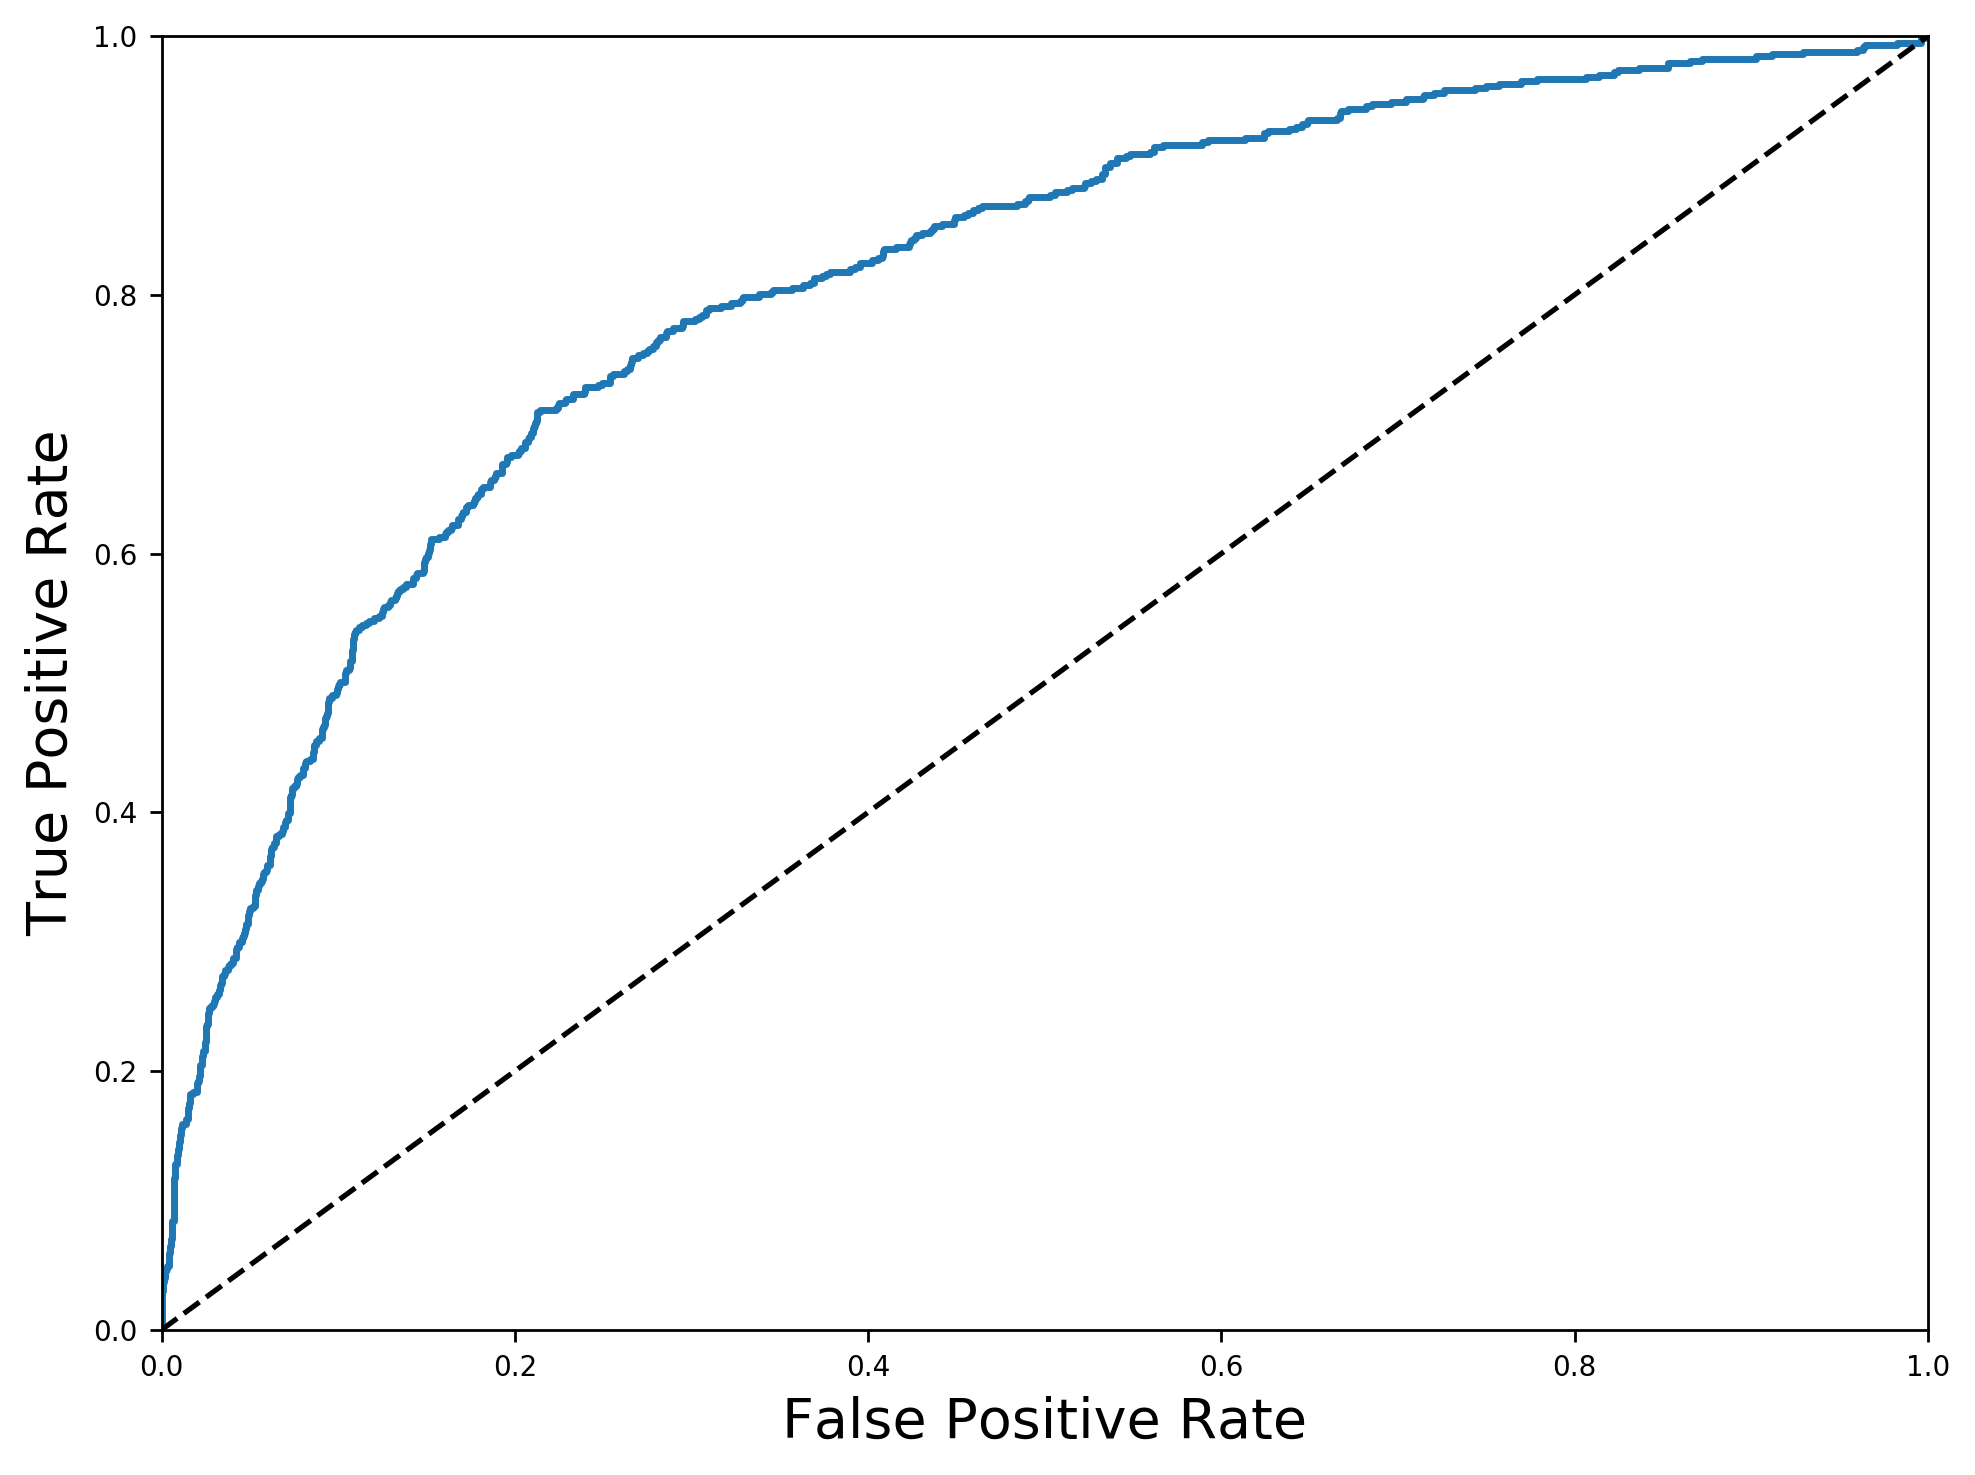

In [99]:
fpr_sgd, tpr_sgd, thresholds_sgd = roc_curve(dataset_train_label_true, y_scores_sgd_clf)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
save_fig("roc_curve_plot")
plt.show()

In [100]:
roc_auc_score(dataset_train_label_true, y_scores_sgd_clf)

0.701223668850725

# Evaluation sur le _jeu de test_

Affichons les courbes ROC de chacun de nos modèles

Saving figure roc_curve_comparison_plot


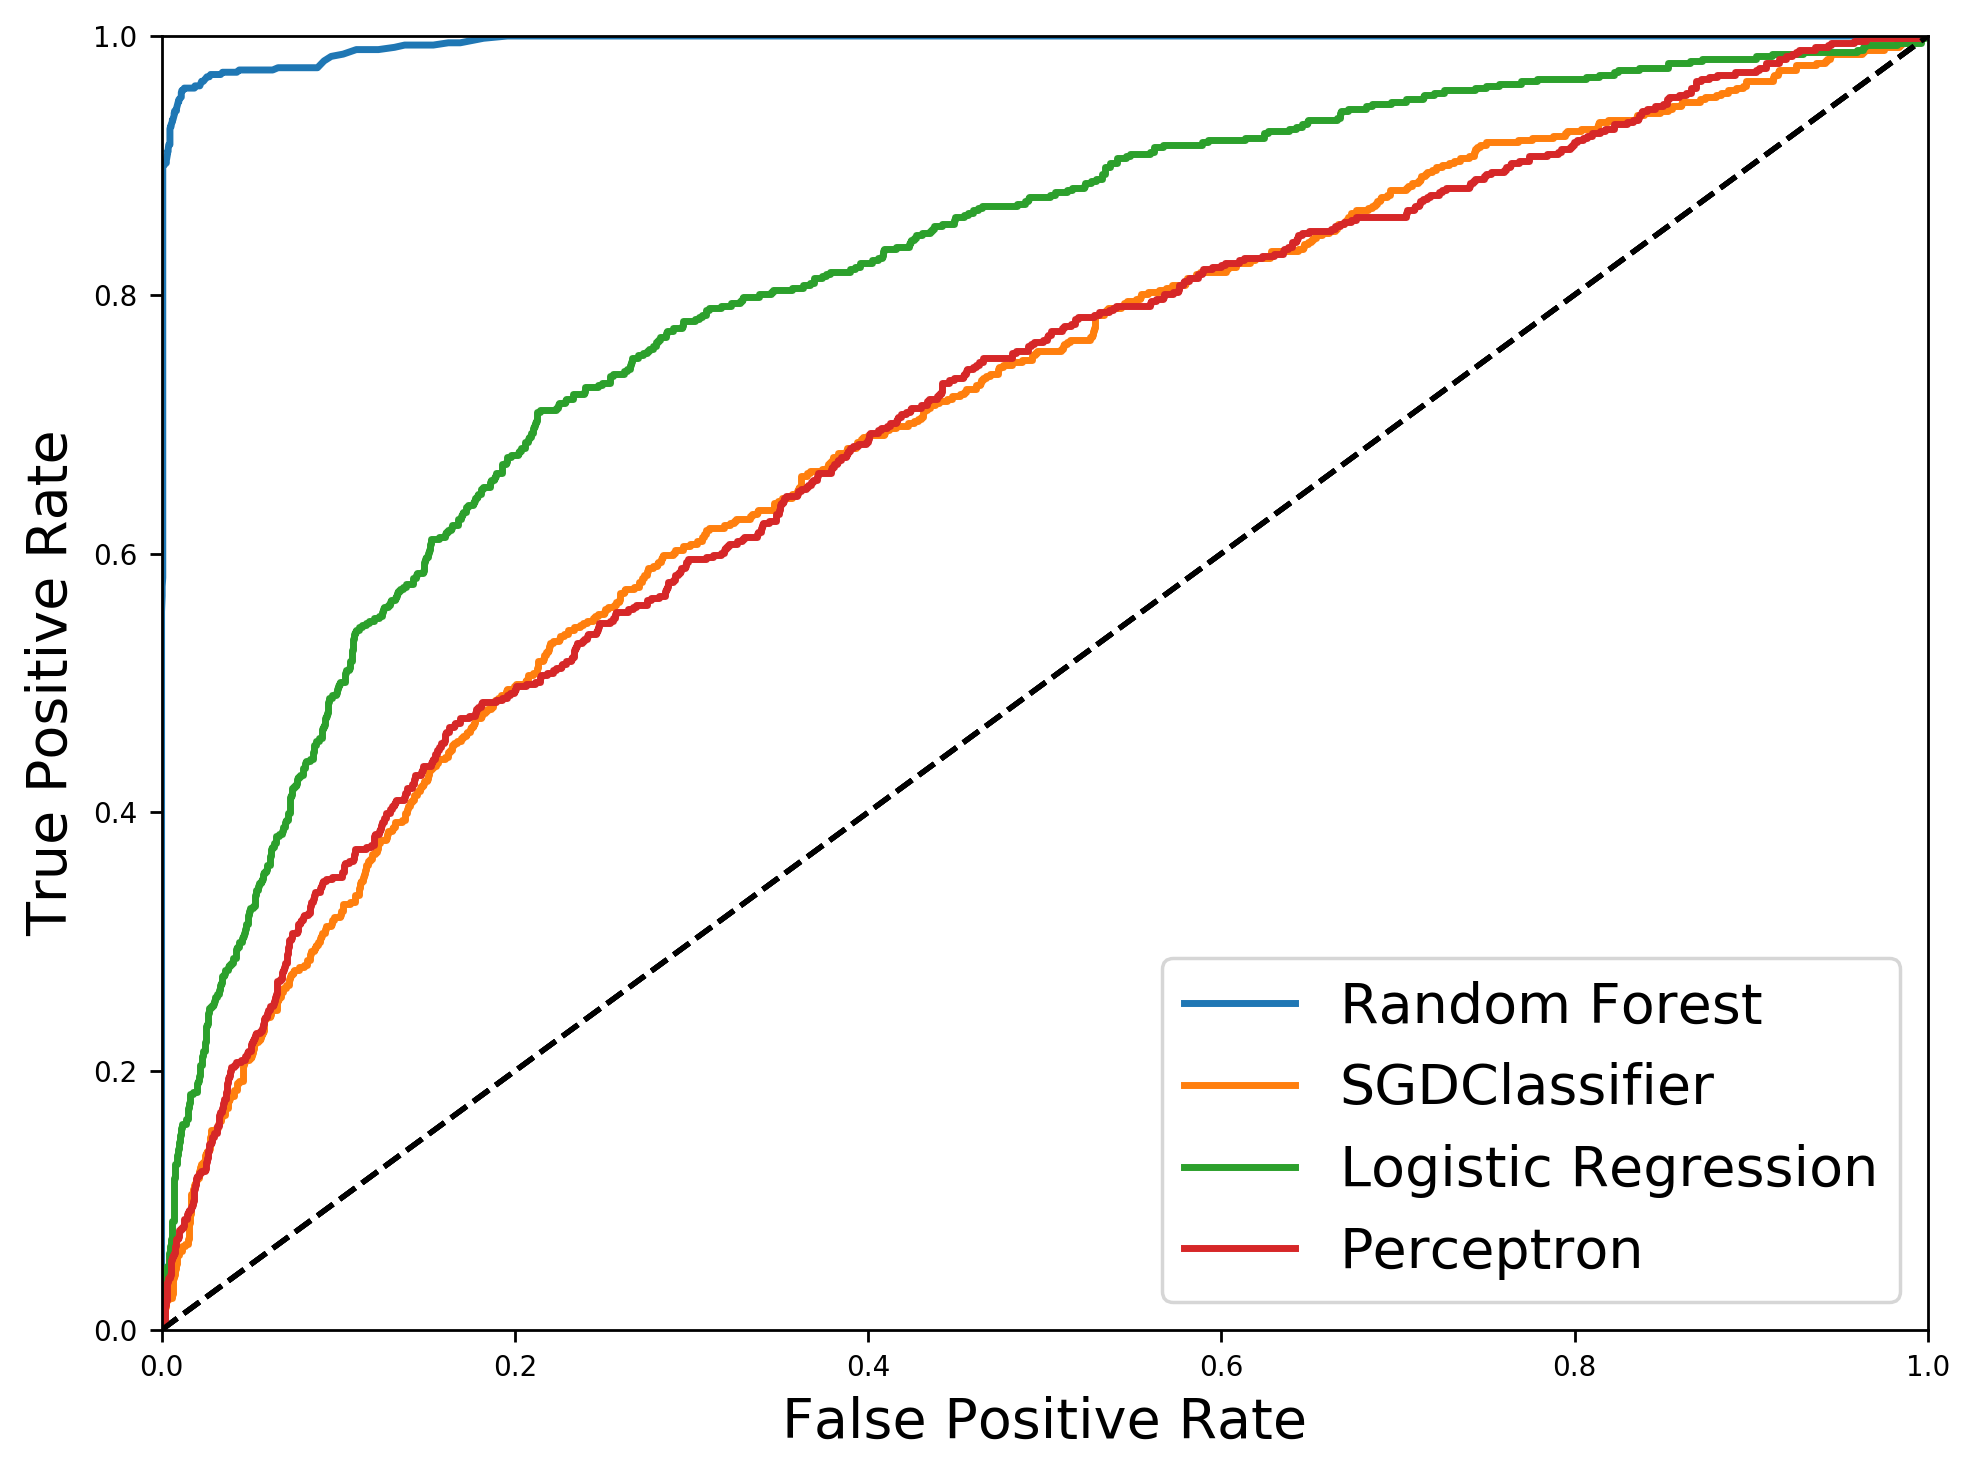

In [101]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plot_roc_curve(fpr_sgd, tpr_sgd, "SGDClassifier")
plot_roc_curve(fpr, tpr, "Logistic Regression")
plot_roc_curve(fpr_percep, tpr_percep, "Perceptron")
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

Avec ce graphique ainsi que les résultats des entrainements des modèles précédents, nous pouvons affirmer que dans notre cas et avec notre jeu de données, le modèle le plus efficace est la Random Forest Classification.

## Prédictions sur le jeu de test

In [102]:
final_model = best_forest_clf
final_threshold = forest_thresholds
X_test = strat_test_set.drop("Attrition", axis=1)

X_test_prepared = full_train_pipeline.transform(X_test)



In [103]:
final_prediction = final_model.predict_proba(X_test_prepared)[:, 1]
final_prediction_set = np.where(final_prediction < final_threshold, 0, 1)

In [104]:
def percentage(unique, counts):
    return (counts[1]/(counts[0]+counts[1]))*100

unique, counts = np.unique(final_prediction_set, return_counts=True)
dict(zip(unique, counts))

{0: 741, 1: 141}

In [105]:
percentage(unique, counts)

15.98639455782313

Avec notre modèle, nous avons prédis que 16% des employés de notre jeu de test ont quitté l'entreprise au cours de l'année 2015, ce qui correspond au pourcentage global des employés ayant quitté l'entreprise en 2015 qui est de 15%.

### Variation des features

Faisons varier les valeurs de nos features les plus importantes afin de voir l'incidence sur le taux d'attrition

#### Variation du temps de travail moyen 

In [106]:
X_test_AverageWorktime = X_test.copy()
X_test_AverageWorktime["AverageWorktime"] = X_test_AverageWorktime["AverageWorktime"].apply(lambda x: x - 0.5)
X_test_AverageWorktime_prepared = full_train_pipeline.transform(X_test_AverageWorktime)

final_AverageWorktime_prediction = final_model.predict_proba(X_test_AverageWorktime_prepared)[:, 1]
final_AverageWorktime_prediction_set = np.where(final_AverageWorktime_prediction < final_threshold, 0, 1)

unique, counts = np.unique(final_AverageWorktime_prediction_set, return_counts=True)
percentage(unique, counts)

15.306122448979592

#### Variation BusinessTravel

In [107]:
X_test_BusinessTravel = X_test.copy()
X_test_BusinessTravel["BusinessTravel"].where(X_test_BusinessTravel["BusinessTravel"] == "Travel_Frequently", "Non-Travel", inplace = True)
X_test_BusinessTravel["BusinessTravel"].where(X_test_BusinessTravel["BusinessTravel"] == "Non-Travel" , "Travel_Rarely", inplace = True)
X_test_BusinessTravel_prepared = full_train_pipeline.transform(X_test_BusinessTravel)

final_BusinessTravel_prediction = final_model.predict_proba(X_test_BusinessTravel_prepared)[:, 1]
final_BusinessTravel_prediction_set = np.where(final_BusinessTravel_prediction < final_threshold, 0, 1)

unique, counts = np.unique(final_BusinessTravel_prediction_set, return_counts=True)
percentage(unique, counts)

15.532879818594104

#### Variation YearsWithCurrManager

In [108]:
X_test_YearsWithCurrManager = X_test.copy()

X_test_YearsWithCurrManager["YearsWithCurrManager"] = X_test_YearsWithCurrManager["YearsAtCompany"].copy()
X_test_YearsWithCurrManager_prepared = full_train_pipeline.transform(X_test_YearsWithCurrManager)

final_YearsWithCurrManager_prediction = final_model.predict_proba(X_test_YearsWithCurrManager_prepared)[:, 1]
final_YearsWithCurrManager_prediction_set = np.where(final_YearsWithCurrManager_prediction < final_threshold, 0, 1)

unique, counts = np.unique(final_YearsWithCurrManager_prediction_set, return_counts=True)
percentage(unique, counts)

15.646258503401361

#### Variation JobSatisfaction

In [109]:
X_test_JobSatisfaction = X_test.copy()
X_test_JobSatisfaction["JobSatisfaction"] = X_test_JobSatisfaction["JobSatisfaction"].apply(lambda x: x + 1)
X_test_JobSatisfaction["JobSatisfaction"].where(X_test_JobSatisfaction["JobSatisfaction"] < 4, 4, inplace = True)

X_test_JobSatisfaction_prepared = full_train_pipeline.transform(X_test_JobSatisfaction)

final_JobSatisfaction_prediction = final_model.predict_proba(X_test_JobSatisfaction_prepared)[:, 1]
final_JobSatisfaction_prediction_set = np.where(final_JobSatisfaction_prediction < final_threshold, 0, 1)

unique, counts = np.unique(final_JobSatisfaction_prediction_set, return_counts=True)
percentage(unique, counts)

15.532879818594104

#### Variation EnvironmentSatisfaction

In [110]:
X_test_EnvironmentSatisfaction = X_test.copy()
#X_test_EnvironmentSatisfaction["EnvironmentSatisfaction"] = X_test_EnvironmentSatisfaction["EnvironmentSatisfaction"].apply(lambda x: x + 1)
#X_test_EnvironmentSatisfaction["EnvironmentSatisfaction"].where(X_test_EnvironmentSatisfaction["EnvironmentSatisfaction"] < 4, 4, inplace = True)

X_test_EnvironmentSatisfaction["EnvironmentSatisfaction"] = np.where(X_test_EnvironmentSatisfaction["EnvironmentSatisfaction"] < 2,
                                          X_test_EnvironmentSatisfaction["EnvironmentSatisfaction"] + 2, 4)

X_test_EnvironmentSatisfaction_prepared = full_train_pipeline.transform(X_test_EnvironmentSatisfaction)

final_EnvironmentSatisfaction_prediction = final_model.predict_proba(X_test_EnvironmentSatisfaction_prepared)[:, 1]
final_EnvironmentSatisfaction_prediction_set = np.where(final_EnvironmentSatisfaction_prediction < final_threshold, 0, 1)

unique, counts = np.unique(final_EnvironmentSatisfaction_prediction_set, return_counts=True)
percentage(unique, counts)

15.646258503401361

#### Variation de YearsSinceLastPromotion

In [111]:
X_test_YearsSinceLastPromotion = X_test.copy()
X_test_YearsSinceLastPromotion["YearsSinceLastPromotion"] = X_test_YearsSinceLastPromotion["YearsSinceLastPromotion"].apply(lambda x: x - 1)
X_test_YearsSinceLastPromotion["YearsSinceLastPromotion"].where(X_test_YearsSinceLastPromotion["YearsSinceLastPromotion"] >= 0, 0, inplace = True)

X_test_YearsSinceLastPromotion_prepared = full_train_pipeline.transform(X_test_YearsSinceLastPromotion)

X_test_YearsSinceLastPromotion_prediction = final_model.predict_proba(X_test_YearsSinceLastPromotion_prepared)[:, 1]
X_test_YearsSinceLastPromotion_prediction_set = np.where(X_test_YearsSinceLastPromotion_prediction < final_threshold, 0, 1)

unique, counts = np.unique(X_test_YearsSinceLastPromotion_prediction_set, return_counts=True)
percentage(unique, counts)

15.759637188208616

#### Variation de MonthlyIncome

In [112]:
X_test_MonthlyIncome = X_test.copy()
X_test_MonthlyIncome["MonthlyIncome"] = X_test_MonthlyIncome["MonthlyIncome"].apply(lambda x: x + (x * (50/100)))

X_test_MonthlyIncome_prepared = full_train_pipeline.transform(X_test_MonthlyIncome)

final_MonthlyIncome_prediction = final_model.predict_proba(X_test_MonthlyIncome_prepared)[:, 1]
final_MonthlyIncome_prediction_set = np.where(final_MonthlyIncome_prediction < final_threshold, 0, 1)

unique, counts = np.unique(final_MonthlyIncome_prediction_set, return_counts=True)
percentage(unique, counts)

15.98639455782313

#### Variation de toutes les features ci-dessus

Observons l'incidence sur le taux de l'attrition de toutes ces features en même temps

In [113]:
X_test_Total = X_test.copy()

X_test_Total["AverageWorktime"] = X_test_Total["AverageWorktime"].apply(lambda x: x - 0.5)

X_test_Total["MonthlyIncome"] = X_test_Total["MonthlyIncome"].apply(lambda x: x + (x * (5/100)))

X_test_Total["BusinessTravel"] = np.where(X_test_Total["BusinessTravel"]  != "Travel_Frequently",
                                          "Non-Travel", "Travel_Rarely")

X_test_Total["YearsWithCurrManager"] = X_test_Total["YearsAtCompany"].copy()

X_test_Total["JobSatisfaction"] = np.where(X_test_Total["JobSatisfaction"]  != 4,
                                           X_test_Total["JobSatisfaction"] + 1, 4)

X_test_Total["EnvironmentSatisfaction"] = np.where(X_test_Total["EnvironmentSatisfaction"] <= 2,
                                          X_test_Total["EnvironmentSatisfaction"] + 2, 4)

X_test_Total["YearsSinceLastPromotion"] = np.where(X_test_Total["YearsSinceLastPromotion"] >= 1,
                                          X_test_Total["YearsSinceLastPromotion"] - 1, 0)

X_test_Total_prepared = full_train_pipeline.transform(X_test_Total)

final_Total_prediction = final_model.predict_proba(X_test_Total_prepared)[:, 1]
final_Total_prediction_set = np.where(final_Total_prediction < final_threshold, 0, 1)

unique, counts = np.unique(final_Total_prediction_set, return_counts=True)

dict(zip(unique, counts))

{0: 806, 1: 76}

In [114]:
percentage(unique, counts)

8.616780045351474

En faisant varier la valeur de toutes ces features, nous presque réussi a diminuer la valeur de l'attrition de moitié, passant de 16% a 8,6%.

Nous pouvons donc à présent proposer des pistes d'amélioration à l'entreprise HumanForYou afin de réduire leur taux de turn-over chaque année (cf rapport)